In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gravis as gv
import networkx as nx

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os


######################################################################################################### 
####                                            Arguments                                           #####
######################################################################################################### 

## account for the folder structure 
import sys
sys.path.append(os.path.abspath("../scr"))


import wandb 

In [7]:
# Replace argparse with a dictionary
# args = {

#     "seed": 42, 

#     'dataset_transform': [],  # Example list of transformations
#     'numbers_list': [0,1,2,3,4,5,6],  #  [7,9],  # List of integers for class selection
#     'N': "all",  # Number of distinct training images per class
#     'supervision_label_val': 10,  # An integer value for supervision

#     # -----graph-----
#     'num_internal_nodes': 1000,  # Number of internal nodes
#     'graph_type': 'fully_connected',  # custom_two_branch 'fully_connected'  stochastic_block fully_connected_w_self  |  Type of graph fully_connected 'stochastic_block_hierarchy'

#     'remove_sens_2_sens': False, 
#     'remove_sens_2_sup': False, 

#     # -----model-----
#     "use_bias": False,
#     "normalize_msg": False, 
#     'model_type': 'IPC',  # Predictive model type; IPC, PC
#     'weight_init': 'fixed 0.001',  # Weight initialization
#     # 'weight_init': 'normal 0.001',  # Weight initialization
#     'T': 5,  # Number of iterations for gradient descent
#     'lr_values': 0.1,  # Learning rate for values
#     'lr_weights': 0.0001,  # Learning rate for weights
#     # 'lr_weights': 0.0005,  # Learning rate for weights
#     'activation_func': 'swish',  # Activation function

#     # -----learning-----
#     'epochs': 10,  # Number of epochs
#     'batch_size': 1,  # Batch size
#     'seed': 42,  # Random seed
#     'optimizer': False,  # Optimizer, can be True with a float value

#     # -----logging-----
#     'use_wandb': 'disabled',  # Wandb mode
# }

args = {
    "seed": 42,
    "dataset_transform": [],  # List of transformations
    "numbers_list": [0, 1, 2, 3, 4, 5, 6],  # List of integers for class selection
    "N": "all",  # Number of training images per class
    "supervision_label_val": 10,  # Integer value for supervision
    "num_internal_nodes": 1000,  # Number of internal nodes
    "graph_type": "fully_connected",  # Type of graph
    "remove_sens_2_sens": False, 
    "remove_sens_2_sup": False, 
    "use_bias": False,
    "normalize_msg": False,
    "model_type": "IPC",  # Predictive model type
    "weight_init": "fixed 0.001",  # Weight initialization
    "T": 5,  # Number of iterations
    "lr_values": 0.1,  # Learning rate for values
    "lr_weights": 0.0001,  # Learning rate for weights
    "activation_func": "swish",  # Activation function
    "epochs": 10,  # Number of epochs
    "batch_size": 1,  # Batch size
    "optimizer": False,  # Optimizer
    "use_wandb": "disabled",  # Wandb mode
    "mode": "training",  # Mode for training or experimenting
    "data_dir": "../data",  # Dataset directory
    "bias_init": "fixed 0.0",  # Bias initialization
    "set_abs_small_w_2_zero": "False",  # Remove small absolute weights
    "tags": "",  # Tags for WandB logging
}


# Access the arguments just like you would with argparse
print(args['dataset_transform'])  # Example of accessing an argument

class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)


# Create an object from the dictionary
args = Args(**args)



[]


In [8]:



# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"
    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"], 
        # "params_general": {
        #     "remove_sens_2_sens": args.remove_sens_2_sens,  # Set from command line
        #     "remove_sens_2_sup": args.remove_sens_2_sup,    # Set from command line
        #     },
        },  
    "seed": args.seed,   
}

print("zzz", args.remove_sens_2_sens, args.remove_sens_2_sup)
graph_params["graph_type"]["params"]["remove_sens_2_sens"] = args.remove_sens_2_sens  
graph_params["graph_type"]["params"]["remove_sens_2_sup"]  = args.remove_sens_2_sup 


if graph_params["graph_type"]["name"] == "stochastic_block":
    
    # override internal nodes if doing clustering
    graph_params["internal_nodes"] = (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

if graph_params["graph_type"]["name"] == "stochastic_block_hierarchy":
    # Configure internal nodes for stochastic_block_hierarchy
    # Define the hierarchical structure with two layers and a final layer
    layer_1_clusters = 49  # First layer has 49 clusters (7x7 grid of 4x4 blocks)
    clusters_per_layer = layer_1_clusters
    num_layers = 2  # Only two layers before the final layer
    final_layer_clusters = 10  # Number of clusters in the final layer

    # Calculate the total internal nodes across the layers
    # - `clusters_per_layer * 16` accounts for the 4x4 nodes per cluster in each layer
    # - The final layer has `final_layer_clusters` nodes
    graph_params["internal_nodes"] = (clusters_per_layer * 16 * num_layers) + final_layer_clusters


if graph_params["graph_type"]["name"] == "two_branch_graph":
    # Configure internal nodes for two_branch_graph
    # This assumes two branches with specified configurations
    branch1_layers, branch1_clusters_per_layer, branch1_nodes_per_cluster = graph_params["branch1_config"]
    branch2_layers, branch2_clusters_per_layer, branch2_nodes_per_cluster = graph_params["branch2_config"]
    
    # Calculate total internal nodes for both branches
    # Branch 1
    branch1_internal_nodes = branch1_layers * branch1_clusters_per_layer * branch1_nodes_per_cluster
    # Branch 2 (Reversed order)
    branch2_internal_nodes = branch2_layers * branch2_clusters_per_layer * branch2_nodes_per_cluster
    
    # The total number of internal nodes will be the sum of both branches
    graph_params["internal_nodes"] = branch1_internal_nodes + branch2_internal_nodes

from dataset import CustomGraphDataset

# Initialize the GraphBuilder
custom_dataset_train = CustomGraphDataset(graph_params, **dataset_params)


dataset_params["batch_size"] = args.batch_size
dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

print("Device \t\t\t:", device)
print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


from helper.plot import plot_adj_matrix

single_graph = custom_dataset_train.edge_index


print("--------------Init DataLoader --------------------")
train_loader = DataLoader(custom_dataset_train, 
                          batch_size=dataset_params["batch_size"], 
                          shuffle=True, 
                          generator=generator_seed,
                          num_workers=1
                          )




NUM_SENSORY = 28*28  # 10

## TODO: FIX HOW TO DO THIS 
#### ---------------------------------------------------------------------------------------------------------------
# sensory_indices    = range(NUM_SENSORY)
# internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
# num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
# supervision_indices = None

# if dataset_params["supervised_learning"]:
#     label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
#     supervision_indices = label_indices
#     num_vertices += 10

# print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
# print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
# print("num_vertices \t\t:", num_vertices)

# if dataset_params["supervised_learning"]:
#   assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
# else:
#   assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"
#### ---------------------------------------------------------------------------------------------------------------

num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices



print(train_loader.batch_size)
for batch, clean_image in train_loader:
    
    values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
    x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
    print("edge_index", edge_index.shape)

    print(batch.x[:, 0].shape)
    print(custom_dataset_train.edge_index.shape)
    

    full_batch = edge_index

    break




######################################################################################################### 
####                                            VALIDATION                                          #####
######################################################################################################### 
 
# from helper.validate_MP import validate_messagePassing
# validate_messagePassing()

######################################################################################################### 
####                                            FIND OPTIMAL LR                                     #####
######################################################################################################### 
""" 
SKIPPING FOR NOW, see local  
"""



######################################################################################################### 
####                                              Model  (setup)                                    #####
######################################################################################################### 

# lr_gamma, lr_alpha =  (0.1 ,  0.0001)
# lr_gamma, lr_alpha =  (0.1, 0.00001)


model_params = {
    
    'num_vertices': num_vertices,
    'sensory_indices': (sensory_indices), 
    'internal_indices': (internal_indices), 
    "supervised_learning": (supervision_indices),

    "lr_params": (args.lr_values, args.lr_weights),
    #   (args.lr_gamma, args.lr_alpha), 
    "T": args.T,
    "graph_structure": custom_dataset_train.edge_index_tensor, 
    "batch_size": train_loader.batch_size, 
    'edge_type': custom_dataset_train.edge_type, 
    "use_bias": args.use_bias,
 
    "use_learning_optimizer": args.optimizer if not args.optimizer  else [args.optimizer],    # False or [0], [(weight_decay=)]
    
    # "weight_init": "uniform",   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "weight_init": args.weight_init,   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "activation": args.activation_func,  
    "clamping": None , # (0, torch.inf) or 'None' 

    "normalize_msg": args.normalize_msg,
 }

# 

learning_params = model_params.copy()
learning_params['sensory_indices'] = list(learning_params['sensory_indices'])
learning_params['internal_indices'] = list(learning_params['internal_indices'])
learning_params['supervised_learning'] = list(learning_params['supervised_learning'])
# learning_params['transform'] = transform.to_dict()["transform"]
learning_params['dataset_transform'] = args.dataset_transform

learning_params['graph_structure'] = (learning_params['graph_structure']).cpu().numpy().tolist()

model_params_name = f"num_internal_nodes_{args.num_internal_nodes}_T_{args.T}_lr_weights_{args.lr_weights}_lr_values_{args.lr_values}_batch_size_{train_loader.batch_size}"

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    
    raise TypeError('Unknown type:', type(obj))

# combi of learning params and dataset params
params_dict = {**dataset_params, **learning_params}


import json

from datetime import datetime




save_model_params = False

GRAPH_TYPE = graph_params["graph_type"]["name"]    #"fully_connected"
# GRAPH_TYPE = "test"    #"fully_connected"

date_hour = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

model_dir = f"trained_models/test/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"
# model_dir = f"trained_models/{args.model_type.lower()}/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"

# Define the directory path
print("Saving model, params, graph_structure to :", model_dir)

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# For saving, validation, re-creation 
os.makedirs(os.path.join(model_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "parameter_info"), exist_ok=True)

# For testing the model
os.makedirs(os.path.join(model_dir, "eval"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/generation"), exist_ok=True)
# os.makedirs(os.path.join(model_dir, "reconstruction"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/classification"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/denoise"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/occlusion"), exist_ok=True)

# Monitor during training
os.makedirs(os.path.join(model_dir, "energy"), exist_ok=True)

# plot_adj_matrix(single_graph, model_dir, 
#                 node_types=(sensory_indices, internal_indices, supervision_indices))
# plot_adj_matrix(full_batch, model_dir, node_types=None)



Using device: cuda
Seed used 42
Device name:  NVIDIA GeForce MX130
zzz False False
Supervised learning
Taking first n=all digits from each class
graph_params {'internal_nodes': 1000, 'supervised_learning': True, 'graph_type': {'name': 'fully_connected', 'params': {'remove_sens_2_sens': False, 'remove_sens_2_sup': False}}, 'seed': 42}
Setting seed: 42
--------Init base indices for sensory, internal, supervision nodes--------
--------Updating base indices for sensory, internal, supervision nodes--------
{'remove_sens_2_sens': False, 'remove_sens_2_sup': False}
Creating graph structure for fully_connected
Recalculating the number of vertices after graph creation
graph created
self.edge_index torch.Size([2, 3216642])
---------save_graph_to_file--------------------
Graph data saved in graphs/fully_connected/_normal/42
-----Done-----
1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

In [9]:
num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices

print(num_vertices)
print(sensory_indices)  
print(internal_indices)
print(supervision_indices)

1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

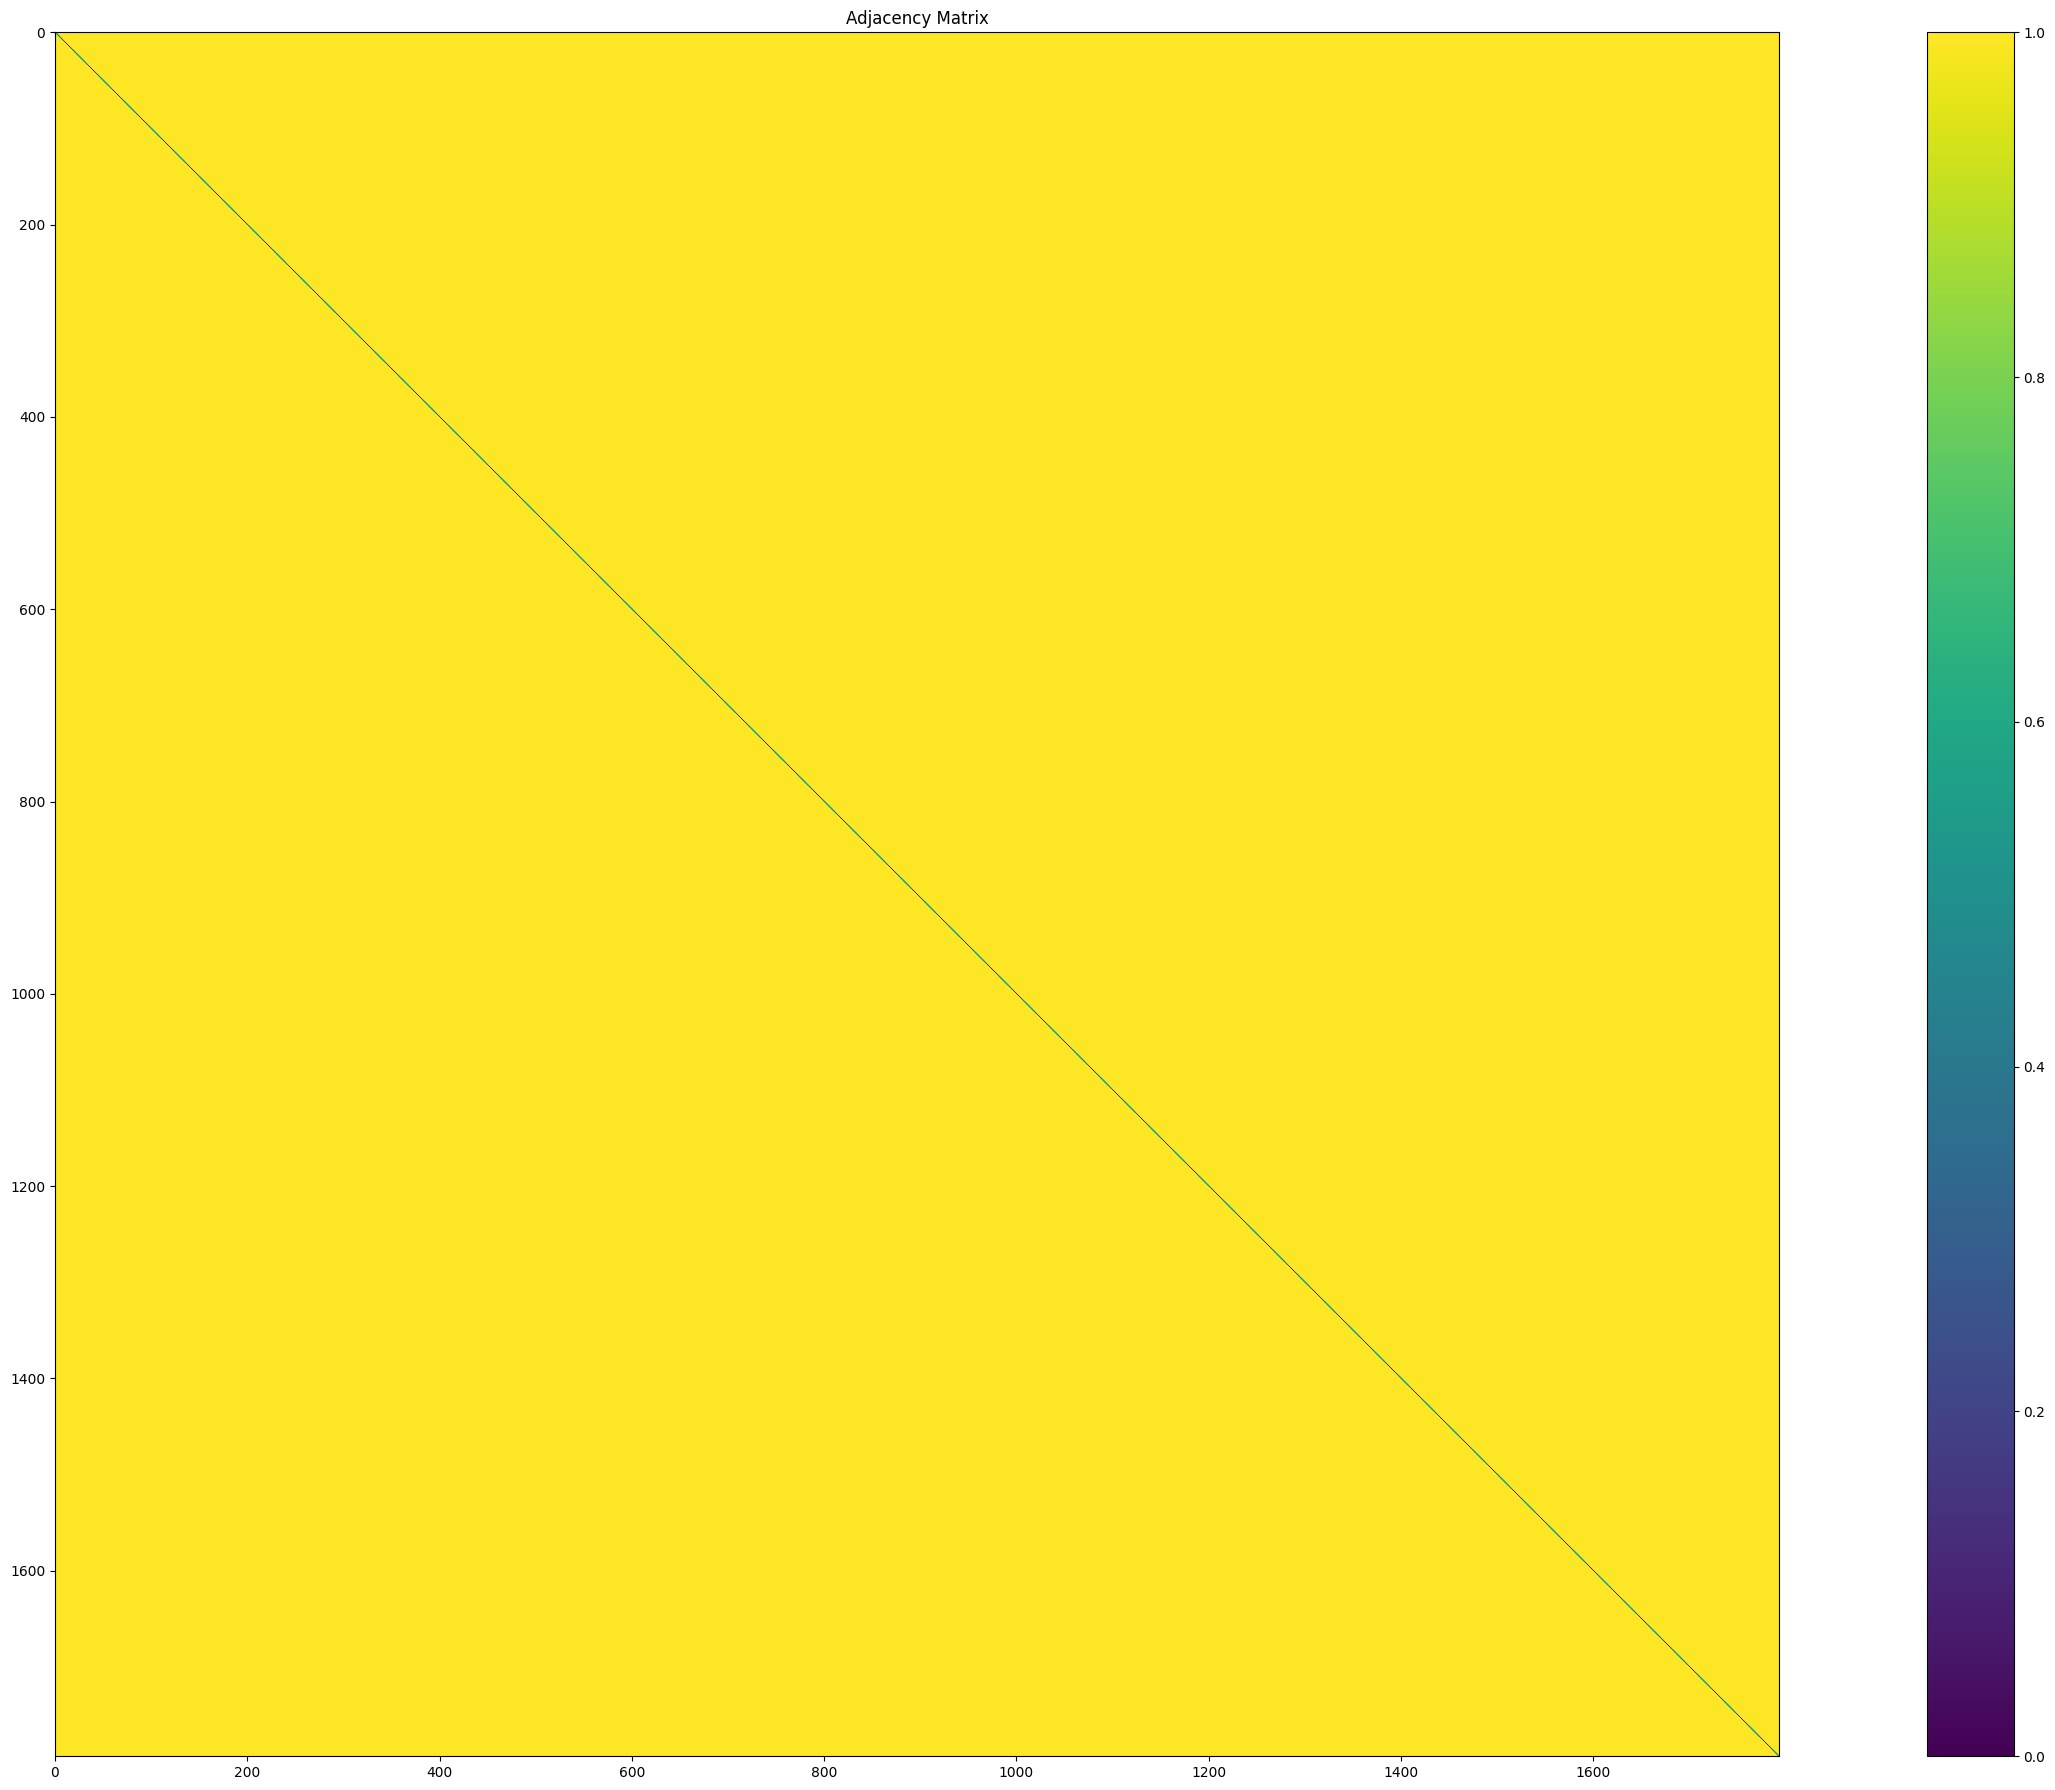

In [10]:
single_graph = custom_dataset_train.edge_index

plot_adj_matrix(single_graph, model_dir=None, node_types=None)


In [11]:
args.use_wandb

'disabled'

In [12]:
import wandb 

run = wandb.init(
    mode=args.use_wandb,
    # entity="Erencan Tatar", 
    project=f"PredCod",
    name=f"T_{args.T}_lr_value_{args.lr_values}_lr_weights_{args.lr_weights}_",
    id=f"{model_params_name}_{date_hour}",
    # tags= 
    dir=model_dir,
    

    # tags=["param_search", str(model_params["weight_init"]), model_params["activation"],  *learning_params['dataset_transform']], 
    # Track hyperparameters and run metadata
    config={
        "supervised_learning": (graph_params["supervised_learning"]),

        "lr_params": (args.lr_values, args.lr_weights), 
        "T": args.T,

        "graph_structure": args.graph_type, 
        "model_type": args.model_type.lower(), 
        # "graph_structure": custom_dataset_train.edge_index_tensor, 
        # "include_self_connections": dataset_params['include_self_connections'],
        "batch_size": train_loader.batch_size, 
        "use_learning_optimizer": model_params["use_learning_optimizer"],    # False or [0], [(weight_decay=)]
        "weight_init":  model_params["weight_init"],   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
        "activation":  model_params["activation"],  
        "clamping": model_params["clamping"], # (0, torch.inf) or 'None' 

        "numbers_list":         dataset_params["numbers_list"],    
        "N":                    dataset_params['N'],     # taking the first n instances of each digit or use "all"

        "transform": learning_params['dataset_transform'],
    },
)

# Contains graph edge matrix and other parameters so quite big to open.
if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_full.txt", 'w') as file:
        json.dump(params_dict, file, default=default)
    print('Done')

# Store the exact command-line arguments in a text file
import sys
command = ' '.join(sys.argv)
with open(model_dir +'parameter_info/command_log.txt', 'w') as f:
    f.write(command)

with open('trained_models/current_running.txt', 'w') as f:
    f.write(model_dir)

# Save the (small) dictionary to a text file
params_dict_small = {}
keys_to_copy = ['supervised_learning', 'numbers_list', 'NUM_INTERNAL_NODES',  
                'N',  'batch_size','use_learning_optimizer', 'weight_init', 'activation', ]
# copy value from params_dict to params_dict_small
for key in keys_to_copy:
    params_dict_small[key] = params_dict[key]

if "dataset_transform" in params_dict:
    params_dict_small["dataset_transform"] = params_dict["dataset_transform"]

if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_small.txt", 'w') as file:
        json.dump(params_dict_small, file, default=default)
    print('Done')

print(f"Using batch size of \t: {train_loader.batch_size}")
print("Device \t\t\t:",          device)
print("Model type \t\t:", args.model_type.lower())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using batch size of 	: 1
Device 			: cuda
Model type 		: ipc


In [14]:
batch

DataBatch(x=[1794, 3, 1], edge_index=[2, 1248364], edge_attr=[1248364], y=[1], batch=[1794], ptr=[2])

In [15]:
# model_params["normalize_msg"] = True 
# model_params["weight_init"] = 0.001
# model_params["weight_init"] = "fixed 0.001"
# model_params["weight_init"] = "normal 0.001"
# model_params["use_learning_optimizer"] = [0.1]
# model_params["use_learning_optimizer"] = False
# model_params["T"] = 50


In [30]:

# args.model_type = "ipc"
args.model_type = "pc"
# 

In [17]:
args.model_type

'ipc'

In [31]:
model_params['use_learning_optimizer'] = [0]

In [32]:
model = None 
from helper.plot import plot_energy_during_training

if args.model_type.lower() == "pc":
        
    from models.PC import *

    model = PCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)

    print("-----------Loading PC model-----------")

if args.model_type.lower() == "ipc":
        
    from models.IPC import  *

    model = IPCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)
    print("-----------Loading IPC model-----------")

# Magic
# wandb.watch(model, 
#             log="all",   # (str) One of "gradients", "parameters", "all", or None
#             log_freq=10)


from helper.plot import plot_model_weights


save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch0.png')
# plot_model_weights(model, save_path)

######################################################################################################### 
####                                              Model  (training)                                 #####
######################################################################################################### 
model.pc_conv1.set_mode("training")

------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
----- using grokfast: False
----- using use_bias: False
check ______________-- [0]
------------Using optimizers with weight_decay 0 ------------
Using self.adjust_delta_w,  False
normalize_msg False
-------------initialize--------------
-------------Activation func set to swish--------------
-----------Loading PC model-----------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode training--------------
-------------task None--------------


# Learn in stages

# Original Learning

In [25]:
# model.pc_conv1.T = 20


In [29]:
graph_params

{'internal_nodes': 1000,
 'supervised_learning': True,
 'graph_type': {'name': 'custom_two_branch',
  'params': {'branch1_config': (2, 5, 10),
   'branch2_config': (2, 5, 10),
   'remove_sens_2_sens': False,
   'remove_sens_2_sup': False}},
 'seed': 42}

In [ ]:
model.pc_conv1.

In [35]:
from helper.plot import plot_energy_during_training

import time 
torch.cuda.empty_cache()

training_labels = [] 
from collections import Counter


print(model)      

model = model.to(device)
# assert train_loader.batch_size == 1
print(len(train_loader))
print("Starting training")


# Initialize early stopping and history
earlystop = False
history = {
    "internal_energy_per_epoch": [],
    "sensory_energy_per_epoch": [],
    "internal_energy_per_batch_last": [],
    "sensory_energy_per_batch_last": [],
}

# Define the early stopping threshold and OOM warning
threshold_earlystop = 0.05
max_energy_threshold = 1e6

start_time = time.time()

for epoch in range(args.epochs):
# for epoch in range(1):
    total_loss = 0
    last_loss = 1e10

    if earlystop:
        break

    for idx, (batch, clean) in enumerate(train_loader):
        torch.cuda.empty_cache()
        
        training_labels.append(int(batch.y))
        try:
            print("Label:", batch.y, "Input Shape:", batch.x.shape)
            model.train()
            # model.pc_conv1.restart_activity()

            batch = batch.to(device)
            history_epoch = model.learning(batch)

            # Append energy values to history
            history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
            history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])
            history["internal_energy_per_batch_last"].append(history_epoch["internal_energy_last"])
            history["sensory_energy_per_batch_last"].append(history_epoch["sensory_energy_last"])

            model.pc_conv1.restart_activity()

            print(f"------------------ Epoch {epoch}: Batch {idx} ------------------")

            # Periodic checkpoint saving and plotting


            # Early stopping based on loss change
            if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
                print()
                earlystop = True
                print(f"EARLY STOPPED at epoch {epoch}")
                print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
                break

            # Early stopping based on high energy
            if history_epoch["internal_energy_mean"] > max_energy_threshold:
                print("energy :", history_epoch["internal_energy_mean"])
                print("Energy too high, stopping training")
                earlystop = True
                break

            if idx >= 10:
                print("Epoch checkpoint reached, saving model...")

                # model_filename = f"model_state_dict_{epoch}.pth"
                # model_path = os.path.join(model_dir, model_filename)
                # torch.save(model.state_dict(), model_path)


                from helper.plot import plot_energy_during_training

                plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=model_dir,
                                            epoch=epoch)

                break 


        
        except RuntimeError as e:
            
            if 'out of memory' in str(e):
                print('WARNING: CUDA ran out of memory, skipping batch...')
                torch.cuda.empty_cache()
                continue
            else:
                torch.cuda.empty_cache()
                raise e

    print(f"Epoch {epoch} / {args.epochs} completed")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
# plot_model_weights(model, save_path)

if earlystop:
    print("Stopping program-------")
    # Open the file in write mode
    with open(model_dir + "early_stopped_training.txt", 'w') as file:
        # Write each list to the file

        file.write("Stopped training :\n")
    exit()


PCGNN(
  (pc_conv1): PCGraphConv(
    (prediction_mp): PredictionMessagePassing()
    (values_mp): ValueMessagePassing()
  )
)
41935
Starting training
Done for idx 23335
Done for idx 35170
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.160824775695801


Done for idx 20389


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 4.144694805145264
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9160, device='cuda:0') tensor(-0.0104, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0583, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
Done for idx 8060
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 4.29293155670166
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 0 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.9386563301086426


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.924276351928711
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9414, device='cuda:0') tensor(-0.0047, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0525, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 3.002763271331787
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 1 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 17030
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.452764511

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


trace len 0
Final internal energy (t=T): 2.450334072113037
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9366, device='cuda:0') tensor(-0.0140, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0394, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.5030148029327393
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 2 ------------------
Done for idx 34942
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.994846820831299


torch.Size([1794])


Iteration 1, Energy: {'internal_energy': 4.98684024810791, 'supervised_energy': 49.141265869140625, 'sensory_energy': 71.02416229248047, 'energy_total': 125.15228271484375}:   0%|          | 0/5 [00:00<?, ?it/s]



torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 4.958860397338867
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9088, device='cuda:0') tensor(-0.0006, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0709, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 5.222564697265625
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 3 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 1207
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.5612447857

torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.54046231508255
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9445, device='cuda:0') tensor(0.0162, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0382, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 15204
Internal energy after weight update (t=T+1): 0.5976329445838928
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 4 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.054593801498413


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 3.05399227142334
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9167, device='cuda:0') tensor(-0.0083, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0494, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 3.1499695777893066
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 5 ------------------
Done for idx 12855
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.316638708114624


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 1.3103411197662354
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9817, device='cuda:0') tensor(0.0008, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0375, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.3575488328933716
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 6 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 19506
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.815642833709717


torch.Size([1794])


torch.Size([1794])


Iteration 2, Energy: {'internal_energy': 4.805985927581787, 'supervised_energy': 49.66273880004883, 'sensory_energy': 78.64385986328125, 'energy_total': 133.11257934570312}:  20%|██        | 1/5 [00:00<00:00, 12.02it/s]







torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 4.793630123138428
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9598, device='cuda:0') tensor(0.0072, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0744, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 5.033203125
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 7 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 21063
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.1943515539169312


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.1707693338394165
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9921, device='cuda:0') tensor(0.0303, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0571, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.3089570999145508
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 8 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 3236
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.7915573120117188


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Iteration 4, Energy: {'internal_energy': 1.7826805114746094, 'supervised_energy': 49.649051666259766, 'sensory_energy': 49.32164001464844, 'energy_total': 100.75337219238281}:  60%|██████    | 3/5 [00:00<00:00, 25.13it/s]





torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.7807964086532593
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9620, device='cuda:0') tensor(0.0084, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0495, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 23902
Internal energy after weight update (t=T+1): 1.9111666679382324
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 9 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 10.047158241271973


torch.Size([1794])
torch.Size([1794])


Iteration 2, Energy: {'internal_energy': 10.072588920593262, 'supervised_energy': 49.5225715637207, 'sensory_energy': 65.64413452148438, 'energy_total': 125.23929595947266}:  20%|██        | 1/5 [00:00<00:00, 13.40it/s]











torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 10.111032485961914
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9376, device='cuda:0') tensor(-0.0328, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0728, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 9.969833374023438
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 0 / 10 completed
Done for idx 12136
Done for idx 24277
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
------------

Done for idx 




Iteration 2, Energy: {'internal_energy': 5.251363754272461, 'supervised_energy': 49.314334869384766, 'sensory_energy': 54.68389129638672, 'energy_total': 109.24958801269531}:  20%|██        | 1/5 [00:00<00:00, 12.95it/s]

26944


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 5.260842323303223
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9222, device='cuda:0') tensor(-0.0152, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0612, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 24774
Internal energy after weight update (t=T+1): 5.296655654907227
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 0 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.585241794

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 3.5887107849121094
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9450, device='cuda:0') tensor(0.0037, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0585, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 3.6242170333862305
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 1 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 5304
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.467376708984375


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.464099645614624
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9786, device='cuda:0') tensor(0.0079, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0540, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.523118019104004
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 2 ------------------
Done for idx 33662
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.28279972076416


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 4.309957504272461
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9304, device='cuda:0') tensor(-0.0169, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0491, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 4.222092151641846
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 3 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 1683
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.145165920257568


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 4.160250663757324
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9739, device='cuda:0') tensor(-0.0025, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0598, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 4.099083423614502
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 4 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 30589
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.4327960014343262


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


Iteration 3, Energy: {'internal_energy': 1.4322395324707031, 'supervised_energy': 50.03406524658203, 'sensory_energy': 44.499412536621094, 'energy_total': 95.96571350097656}:  40%|████      | 2/5 [00:00<00:00, 19.67it/s]





torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 1.4318656921386719
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0013, device='cuda:0') tensor(0.0104, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0425, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.4478235244750977
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 10442
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.6331585645675659


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.6321659088134766
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9926, device='cuda:0') tensor(-0.0021, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0223, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.6441763639450073
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
Done for idx 14833
------------------ Epoch 1: Batch 6 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.528015613555908


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.5457448959350586
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9535, device='cuda:0') tensor(-0.0074, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0400, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.4686529636383057
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 7 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 16533
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.7754089832305908


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.7723833918571472
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9903, device='cuda:0') tensor(0.0033, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0278, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idx 24492
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.7876967191696167
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 8 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 5.453006267547607


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 5.481767654418945
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9636, device='cuda:0') tensor(0.0076, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0702, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 5.37302827835083
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 9 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 36388
-------------inference--------------
torch.Size([1794])
Initial internal energy (

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.7745357751846313
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9762, device='cuda:0') tensor(-0.0091, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0309, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.6964597702026367
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 1 / 10 completed
Done for idx 7092
Done for idx 11881
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1

Done for idx 5718


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Iteration 3, Energy: {'internal_energy': 1.2614696025848389, 'supervised_energy': 49.628170013427734, 'sensory_energy': 28.277366638183594, 'energy_total': 79.1670150756836}:  60%|██████    | 3/5 [00:00<00:00, 27.62it/s]







torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.262845516204834
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9606, device='cuda:0') tensor(-0.0001, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0329, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.2442188262939453
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 0 ------------------
Done for idx 7046
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.5200424194335938


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 3.5252230167388916
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9684, device='cuda:0') tensor(-0.0044, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0535, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 3.4744718074798584
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 1 ------------------
Done for idx 13018
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.6042024493217468


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.5987917184829712
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9982, device='cuda:0') tensor(0.0030, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0238, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.6078376770019531
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 2 ------------------
Done for idx 36398
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.31687572598457336


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.3091829717159271
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9963, device='cuda:0') tensor(0.0105, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0235, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.31220656633377075
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 3 ------------------
Done for idx 2284
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.5772405862808228


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.5714002847671509
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9928, device='cuda:0') tensor(0.0004, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0217, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.5817883610725403
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 11951
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.417246699333191


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.4184489250183105
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9769, device='cuda:0') tensor(-0.0047, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0305, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.3856382369995117
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 5 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.403172254562378


Done for idx

Total energy at time 0 {'internal_energy': 1.403172254562378, 'supervised_energy': 49.58460998535156, 'sensory_energy': 25.423828125, 'energy_total': 76.41160583496094}:   0%|          | 0/5 [00:00<?, ?it/s]

16358


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.4081010818481445
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9555, device='cuda:0') tensor(-0.0056, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0311, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.390892744064331
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 6 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 20156
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.7966861724853516


torch.Size([1794])
torch.Size([1794])


Iteration 2, Energy: {'internal_energy': 2.803274393081665, 'supervised_energy': 49.78364562988281, 'sensory_energy': 52.572330474853516, 'energy_total': 105.15924835205078}:  20%|██        | 1/5 [00:00<00:00, 14.40it/s]







torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 2.812124252319336
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9744, device='cuda:0') tensor(0.0045, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0479, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.7279160022735596
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 7 ------------------
Done for idx 11115
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 7.0911736488342285


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 7.196846008300781
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9993, device='cuda:0') tensor(-0.0116, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0641, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 6.851771354675293
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 8 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 20848
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.309903144836426


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 4.302757263183594
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9048, device='cuda:0') tensor(0.0049, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0622, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 4.21909236907959
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 9 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 38804
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.9711053967475891


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.945024311542511
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9992, device='cuda:0') tensor(0.0249, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0427, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.9599472284317017
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 2 / 10 completed
Done for idx 39469
Done for idx 11962
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial intern

Done for idx

Iteration 2, Energy: {'internal_energy': 6.854230880737305, 'supervised_energy': 50.253299713134766, 'sensory_energy': 63.55613708496094, 'energy_total': 120.66366577148438}:  40%|████      | 2/5 [00:00<00:00, 19.71it/s]

38299torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 6.908411026000977
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0136, device='cuda:0') tensor(-0.0144, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0607, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 6.541237831115723
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 0 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 12157
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.412717819213867


torch.Size([1794])


Iteration 1, Energy: {'internal_energy': 3.422083854675293, 'supervised_energy': 50.355220794677734, 'sensory_energy': 55.731353759765625, 'energy_total': 109.50865936279297}:   0%|          | 0/5 [00:00<?, ?it/s]









torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 3.4546852111816406
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0285, device='cuda:0') tensor(0.0041, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0492, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 3.2387380599975586
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 1 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 14112
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.5547342300415039


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.5486311912536621
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0144, device='cuda:0') tensor(-0.0020, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0182, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.5525616407394409
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
Done for idx ------------------ Epoch 3: Batch 2 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
11042
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.5550289154052734


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.5316309928894043
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0107, device='cuda:0') tensor(0.0158, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0420, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.5185123682022095
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 3 ------------------
Done for idxLabel: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
 2156
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.441864490509033


torch.Size([1794])


Iteration 1, Energy: {'internal_energy': 2.4383912086486816, 'supervised_energy': 50.248268127441406, 'sensory_energy': 66.869873046875, 'energy_total': 119.55653381347656}:   0%|          | 0/5 [00:00<?, ?it/s]






Iteration 3, Energy: {'internal_energy': 2.4322757720947266, 'supervised_energy': 50.255863189697266, 'sensory_energy': 67.02572631835938, 'energy_total': 119.7138671875}:  60%|██████    | 3/5 [00:00<00:00, 28.80it/s]

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 2.4265694618225098
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0229, device='cuda:0') tensor(0.0258, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0539, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.3385977745056152
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 4 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 41119
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.8557047843933105


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.8430458903312683
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0244, device='cuda:0') tensor(0.0054, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0264, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8557853698730469
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 5 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 26813
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.6778075695037842


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.663246750831604
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0185, device='cuda:0') tensor(0.0062, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0249, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.6744025349617004
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 6 ------------------
Done for idx 11674
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.211489677429199


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.1326472759246826
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9547, device='cuda:0') tensor(0.0254, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0560, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.2244763374328613
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 7 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 7349
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.6781163215637207


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 2.6378133296966553
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0374, device='cuda:0') tensor(0.0220, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0560, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.6963415145874023
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 8 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 39531
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.6179709434509277


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.6009238958358765
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0363, device='cuda:0') tensor(0.0250, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0343, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.6259511113166809
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 9 ------------------
Done for idx 8126
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.1423065662384033


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.1252562999725342
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0172, device='cuda:0') tensor(0.0158, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.1649038791656494
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 3 / 10 completed
Done for idx 5870
Done for idx 26467
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
------------

Done for idx 12916


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Iteration 3, Energy: {'internal_energy': 0.7322282195091248, 'supervised_energy': 50.1708984375, 'sensory_energy': 24.163089752197266, 'energy_total': 75.06621551513672}:  60%|██████    | 3/5 [00:00<00:00, 27.46it/s]







torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.7278041839599609
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0176, device='cuda:0') tensor(0.0051, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0242, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.7485870122909546
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 0 ------------------
Done for idx 34023
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.8495335578918457


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.856453537940979
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0573, device='cuda:0') tensor(0.0269, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0484, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.8984416723251343
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 1 ------------------
Done for idx 32727
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.915215015411377


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.9140588045120239
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0276, device='cuda:0') tensor(0.0004, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0236, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx Internal energy after weight update (t=T+1): 0.9317740201950073
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 2 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
16316
torch.Size([1794])
Initial internal energy (t=0): 0.47773176431655884


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.4568819999694824
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9974, device='cuda:0') tensor(0.0223, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0318, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.48315995931625366
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 3 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 6828
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.065031051635742


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 3.0757510662078857
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0657, device='cuda:0') tensor(0.0287, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0606, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 6722
Internal energy after weight update (t=T+1): 3.1124000549316406
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.4181408882141113


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.407806873321533
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9569, device='cuda:0') tensor(-0.0051, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0389, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.4447484016418457
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 5 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 12876
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.646852731704712


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.6320059299468994
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0103, device='cuda:0') tensor(0.0481, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0590, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.6998381614685059
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 6 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 121
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.4454560279846191


















Iteration 3, Energy: {'internal_energy': 1.453132152557373, 'supervised_energy': 50.429073333740234, 'sensory_energy': 36.63935089111328, 'energy_total': 88.52156066894531}:  60%|██████    | 3/5 [00:00<00:00, 21.90it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.4575116634368896
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0411, device='cuda:0') tensor(0.0059, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0322, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.4701510667800903
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 7 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 19573
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.4407858848571777


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.4585696458816528
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0421, device='cuda:0') tensor(0.0109, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0349, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.4622585773468018
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 8 ------------------
Done for idx 17989
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.6460723876953125


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.6432440280914307
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0089, device='cuda:0') tensor(0.0410, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0548, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.6802549362182617
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 9 ------------------
Done for idx 30521
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.1442751













Iteration 2, Energy: {'internal_energy': 3.1583425998687744, 'supervised_energy': 49.33808135986328, 'sensory_energy': 55.398094177246094, 'energy_total': 107.89451599121094}:  20%|██        | 1/5 [00:00<00:00, 12.09it/s]

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


Iteration 4, Energy: {'internal_energy': 3.1703906059265137, 'supervised_energy': 49.324920654296875, 'sensory_energy': 55.14183807373047, 'energy_total': 107.63716125488281}:  60%|██████    | 3/5 [00:00<00:00, 25.02it/s]





torch.Size([1794])
trace len 0
Final internal energy (t=T): 3.176217555999756
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9266, device='cuda:0') tensor(0.0116, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0521, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 3.135643482208252
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 4 / 10 completed
Done for idx 41067
Done for idx 9112
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794

Done for idx 14448


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Iteration 3, Energy: {'internal_energy': 0.7899608612060547, 'supervised_energy': 50.024044036865234, 'sensory_energy': 34.613670349121094, 'energy_total': 85.42767333984375}:  40%|████      | 2/5 [00:00<00:00, 18.61it/s]









torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.7897379398345947
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0013, device='cuda:0') tensor(0.0188, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0330, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 41681
Internal energy after weight update (t=T+1): 0.7974635362625122
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 0 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.2188868522644043


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


trace len 0
Final internal energy (t=T): 2.2520558834075928
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0358, device='cuda:0') tensor(0.0130, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0434, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 3348
Internal energy after weight update (t=T+1): 2.198888063430786
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 1 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.2641921043395996


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.289237380027771
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0690, device='cuda:0') tensor(0.0357, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0454, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.264309048652649
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 2 ------------------
Done for idx 360
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 6.55452537536

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 6.618833541870117
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9929, device='cuda:0') tensor(0.0161, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0747, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 12990
Internal energy after weight update (t=T+1): 6.41478967666626
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 3 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.717006206512451


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.7553110122680664
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9806, device='cuda:0') tensor(0.0128, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0479, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idx 9118torch.Size([1794])
Internal energy after weight update (t=T+1): 2.636944532394409
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])

-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 6.063366889953613


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 6.1680803298950195
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0863, device='cuda:0') tensor(0.0367, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0782, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 5.732638359069824
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 5 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 26932
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.461082696914673


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 3.4870049953460693
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0861, device='cuda:0') tensor(0.0278, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0604, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 3.297936201095581
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 6 ------------------
Done for idx Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
24829
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.0423619747161865


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.0487968921661377
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0563, device='cuda:0') tensor(0.0058, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0262, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.025918960571289
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 7 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 19834
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.903829574584961












Iteration 1, Energy: {'internal_energy': 1.9049832820892334, 'supervised_energy': 50.4316291809082, 'sensory_energy': 69.95616149902344, 'energy_total': 122.29276275634766}:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.908846378326416
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0406, device='cuda:0') tensor(0.0382, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0511, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.8083007335662842
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 8 ------------------
Done for idx 9821
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.5268354415893555


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.5243330001831055
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0398, device='cuda:0') tensor(0.0472, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0612, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 12693
Internal energy after weight update (t=T+1): 2.420008659362793
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 9 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.71870154

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.7107290625572205
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0111, device='cuda:0') tensor(0.0166, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0289, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.6849616169929504
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 5: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 5 / 10 completed
Done for idx 13215
Done for idx 3610
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1

Done for idx 7483


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.9485032558441162
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.1009, device='cuda:0') tensor(0.0516, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0565, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idx 17672
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.877431869506836
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 0 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.22111463

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 1.2066603899002075
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0552, device='cuda:0') tensor(0.0455, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0469, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.1861292123794556
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 1 ------------------
Done for idx 33709
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.7371150255203247


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


Iteration 3, Energy: {'internal_energy': 0.7290975451469421, 'supervised_energy': 50.66816711425781, 'sensory_energy': 60.563758850097656, 'energy_total': 111.96102142333984}:  40%|████      | 2/5 [00:00<00:00, 19.81it/s]





torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.7246611714363098
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0664, device='cuda:0') tensor(0.0477, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0421, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.7158764600753784
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 2 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 12142
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.145336151123047


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 4.091858863830566
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.1539, device='cuda:0') tensor(0.0516, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0732, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 4.1197333335876465
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 3 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 11301
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.8397703170776367


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 1.807265281677246
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0403, device='cuda:0') tensor(0.0310, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0473, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.8400096893310547
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 4 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 2042
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.7071341276168823


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.697694718837738
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0539, device='cuda:0') tensor(0.0093, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0224, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.7019730806350708
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 18329
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.9445388317108154


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


Iteration 4, Energy: {'internal_energy': 0.9403348565101624, 'supervised_energy': 50.76868438720703, 'sensory_energy': 37.670387268066406, 'energy_total': 89.37940979003906}:  60%|██████    | 3/5 [00:00<00:00, 24.13it/s]





torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.939449667930603
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0763, device='cuda:0') tensor(0.0181, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0291, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx 33212
Internal energy after weight update (t=T+1): 0.9444152116775513
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 6 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.1631770133972168


torch.Size([1794])
torch.Size([1794])











Iteration 4, Energy: {'internal_energy': 1.1542012691497803, 'supervised_energy': 50.91004180908203, 'sensory_energy': 93.99169921875, 'energy_total': 146.05593872070312}:  60%|██████    | 3/5 [00:00<00:00, 24.91it/s] 

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.1524198055267334
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0885, device='cuda:0') tensor(0.0662, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0552, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idxInternal energy after weight update (t=T+1): 1.1718028783798218
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 7 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
 36917
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.878084659576416


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.8797728419303894
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0639, device='cuda:0') tensor(0.0487, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0432, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8886271715164185
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 8 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 12325
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 3.2418265342712402














Iteration 2, Energy: {'internal_energy': 3.230729818344116, 'supervised_energy': 49.97767639160156, 'sensory_energy': 99.71998596191406, 'energy_total': 152.9283905029297}:  20%|██        | 1/5 [00:00<00:00, 11.64it/s]

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


Iteration 4, Energy: {'internal_energy': 3.2208218574523926, 'supervised_energy': 49.98672103881836, 'sensory_energy': 99.9949951171875, 'energy_total': 153.20254516601562}:  60%|██████    | 3/5 [00:00<00:00, 23.95it/s] 





torch.Size([1794])
trace len 0
Final internal energy (t=T): 3.216684341430664
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.9941, device='cuda:0') tensor(0.0508, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0669, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idxtorch.Size([1794])
Internal energy after weight update (t=T+1): 3.2801098823547363
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 9 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
 24934
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.9185734987258911


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 0.9094464182853699
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0542, device='cuda:0') tensor(0.0334, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0380, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.9283746480941772
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 6: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 6 / 10 completed
Done for idx 40885
Done for idx 3264
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial inter

Done for idx

Iteration 2, Energy: {'internal_energy': 0.7797980308532715, 'supervised_energy': 50.63008117675781, 'sensory_energy': 22.523788452148438, 'energy_total': 73.93367004394531}:  20%|██        | 1/5 [00:00<00:00, 12.48it/s]

4995
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.7792891263961792
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0626, device='cuda:0') tensor(0.0056, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0212, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.7864196300506592
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 0 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 35332
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.4507264

torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.4432932138442993
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0334, device='cuda:0') tensor(0.0252, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0273, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.4511159062385559
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 1 ------------------
Done for idx 25441
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.2400845289230347


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 1.2813853025436401
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.1281, device='cuda:0') tensor(0.0523, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0476, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.2486960887908936
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 2 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 27451
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.7127847075462341


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.7311016321182251
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0957, device='cuda:0') tensor(0.0547, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0426, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Done for idx Internal energy after weight update (t=T+1): 0.7097975015640259
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 3 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
28792
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 4.957587242126465












Iteration 1, Energy: {'internal_energy': 4.966811180114746, 'supervised_energy': 51.407073974609375, 'sensory_energy': 118.78739929199219, 'energy_total': 175.16128540039062}:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 4.998044013977051
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.1297, device='cuda:0') tensor(0.0470, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0740, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 4.84648323059082
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 4 ------------------
Done for idx 30229
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.8638042211532593


torch.Size([1794])


Iteration 1, Energy: {'internal_energy': 0.8692351579666138, 'supervised_energy': 51.13837432861328, 'sensory_energy': 69.70774841308594, 'energy_total': 121.71536254882812}:   0%|          | 0/5 [00:00<?, ?it/s]



torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.8871985673904419
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.1085, device='cuda:0') tensor(0.0509, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0425, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8416045308113098
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 23042
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.0828495025634766


torch.Size([1794])
torch.Size([1794])


Iteration 2, Energy: {'internal_energy': 1.0884678363800049, 'supervised_energy': 50.809593200683594, 'sensory_energy': 37.52716827392578, 'energy_total': 89.42523956298828}:  20%|██        | 1/5 [00:00<00:00, 10.23it/s]





torch.Size([1794])







Iteration 5, Energy: {'internal_energy': 1.0953609943389893, 'supervised_energy': 50.793582916259766, 'sensory_energy': 37.36365509033203, 'energy_total': 89.25260925292969}:  80%|████████  | 4/5 [00:00<00:00, 19.57it/s]

torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 1.0953609943389893
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0786, device='cuda:0') tensor(0.0172, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0289, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.0786405801773071
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 6 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 20172
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 0.8484448194503784


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.8625471591949463
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.1233, device='cuda:0') tensor(0.0661, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0493, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
Done for idx 17113
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8256348371505737
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 7 ------------------
Label: tensor([0]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 2.4689908027648926


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 2.5540521144866943
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.1843, device='cuda:0') tensor(0.0576, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0581, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 2.373323440551758
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 8 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 21571
-------------inference--------------
torch.Size([1794])
Initial internal energ

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.8892847299575806
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0450, device='cuda:0') tensor(0.0397, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0379, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8359791040420532
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 9 ------------------
Done for idx 8350
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial internal energy (t=0): 1.1447800397872925


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


trace len 0
Final internal energy (t=T): 1.1612070798873901
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0955, device='cuda:0') tensor(0.0506, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0438, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 1.0945253372192383
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 7: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 7 / 10 completed
Done for idx 25655
Done for idx 39718
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
torch.Size([1794])
Initial inte

Done for idx 23975


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 0
Final internal energy (t=T): 0.6150290966033936
training
-------------inference done--------------
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(10.0511, device='cuda:0') tensor(0.0393, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0330, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


KeyboardInterrupt: 

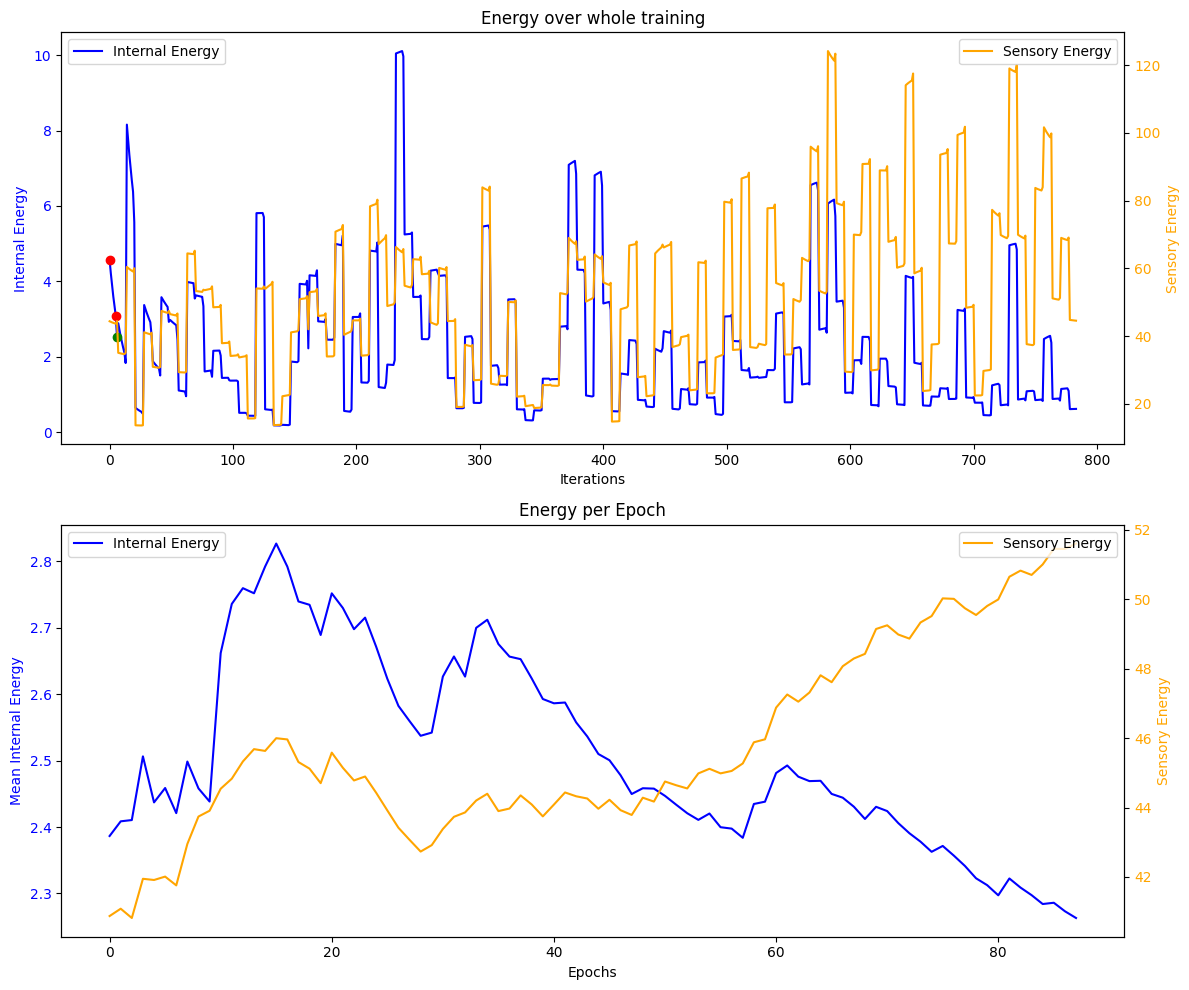

In [36]:
   
plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                            model.pc_conv1.energy_vals["sensory_energy"][:],
                            history, 
                            point1=(0, model.pc_conv1.energy_vals["internal_energy"][0]),
                            point2=(model.pc_conv1.T, model.pc_conv1.energy_vals["internal_energy"][model.pc_conv1.T]),
                            point3=((model.pc_conv1.T)+1, model.pc_conv1.energy_vals["internal_energy"][(model.pc_conv1.T)+1]),
                            model_dir=None,
                            epoch=epoch)

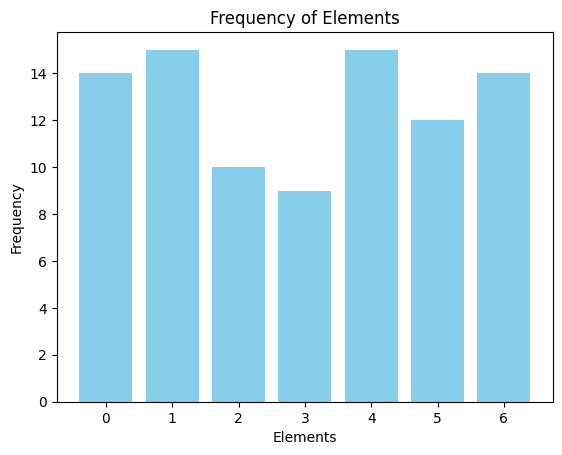

In [37]:

# Sample list
# Create a Counter object
element_counts = Counter(training_labels)

# Prepare data for plotting
labels = list(element_counts.keys())
counts = list(element_counts.values())

# Plot
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.title('Frequency of Elements')
plt.show()

In [19]:
# assert 1 == 2 

In [20]:
# last_loss,  history_epoch["internal_energy_mean"]

tensor(0.1307)


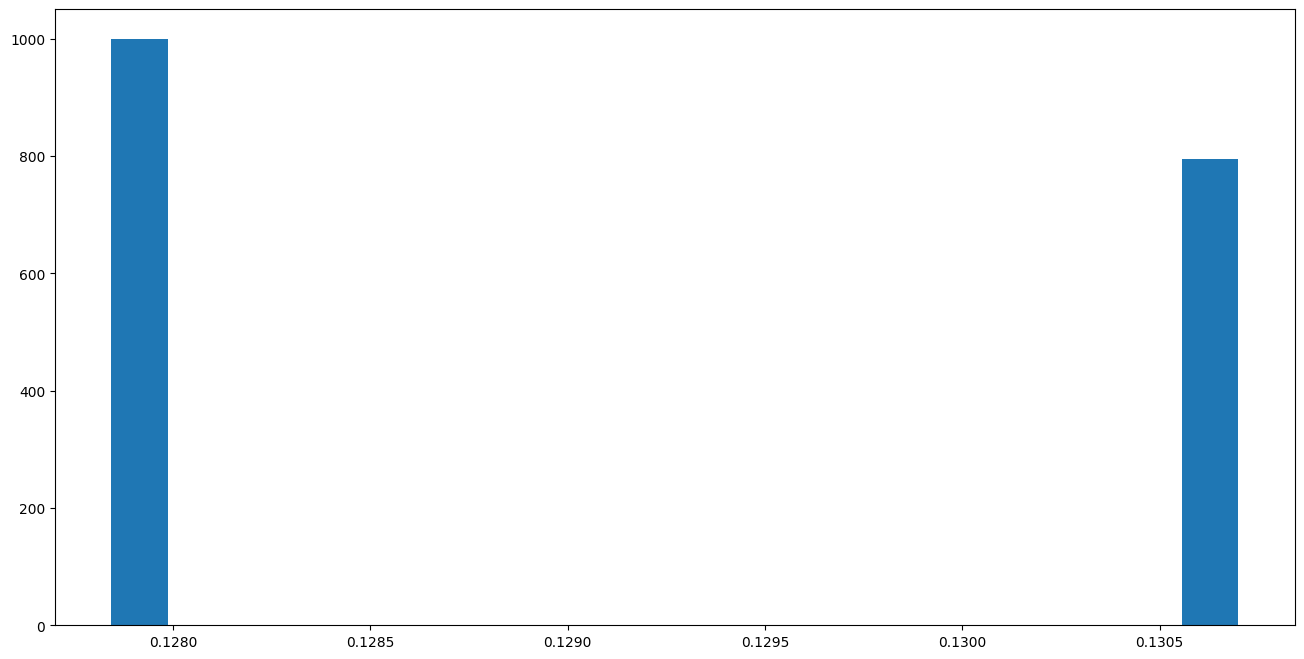

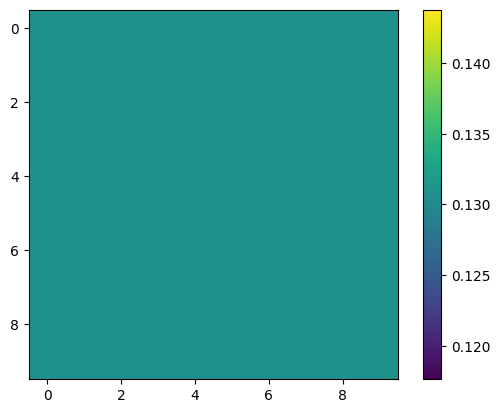

In [21]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:100].reshape(10,10))
    plt.colorbar()
    plt.show()

In [18]:
model.pc_conv1.use_bias

False

In [17]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:2000].reshape(40,50))
    plt.show()

In [23]:
# model_weights_path = "../scr/trained_models/best_models_weights/1/"
# model.save_weights(path=model_weights_path, overide=False)

In [24]:

#     for idx, (batch, clean) in enumerate():
#         torch.cuda.empty_cache()
        
#         try:
#             print("Label:", batch.y, "Input Shape:", batch.x.shape)
#             model.train()
#             # model.pc_conv1.restart_activity()

#             batch = batch.to(device)
#             history_epoch = model.learning(batch)

In [25]:
tmp = iter(train_loader)

batch = next(tmp)

Done for idx 26356
Done for idx 2248


In [26]:
batch[0]

DataBatch(x=[2294, 3, 1], edge_index=[2, 5260142], edge_attr=[5260142], y=[1], batch=[2294], ptr=[2])

In [53]:

# save_path = os.path.join(model_dir, 'parameter_info')
# model.save_weights(path=save_path) 

model.load_weights("../scr/trained_models/best_models_weights/1/", data_eg=batch[0])

Settng weights of self.pc_conv1
loaded weights matrix W
loaded edge index for the graphs
-------------Restarting activity (pred/errors/values)--------------
Done


In [30]:
if model.pc_conv1.use_convergence_monitor:
    model.pc_conv1.convergence_tracker.energy_tracker.energies

    print(model.pc_conv1.convergence_tracker.gradient_tracker.gradients)

[112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672]

In [ ]:
for idx, (batch, clean) in enumerate(train_loader):
    torch.cuda.empty_cache()
    
    img = batch.x[:,0][0:784].cpu()
    plt.imshow(img.view(28,28))

    break 

In [ ]:
import scipy.sparse as sp

# Extract the edge indices and weights
edge_index = model.pc_conv1.edge_index_single_graph.cpu().numpy()

S2S_    = []
rest_   = []
for weights in model.pc_conv1.w_log:

    # Create a sparse matrix using the edge indices and weights
    W_sparse = sp.coo_matrix((weights.cpu(), (edge_index[0], edge_index[1])), shape=(model.pc_conv1.num_vertices, model.pc_conv1.num_vertices))

    # Convert to dense for detailed visualization (if the graph is not too large)
    W = W_sparse.toarray()

    S2S = W[0:784, 0:784]
    S2S_.append(S2S.max()) #, S2S.min())

    rest = W[784:, 784:]
    rest_.append(rest.max()) # rest.min())


print(np.array(S2S_).mean())
print(np.array(rest_).mean())

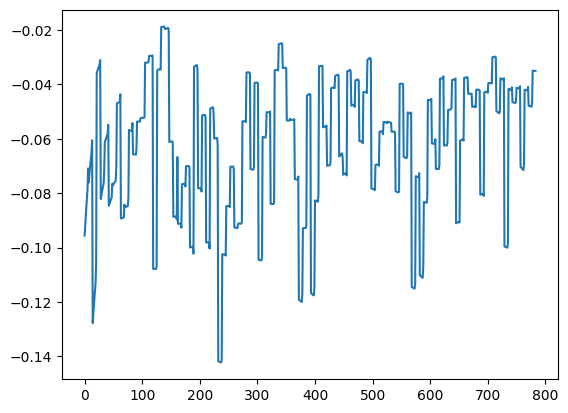

Exception ignored in: <function tqdm.__del__ at 0x7bb13616f1c0>
Traceback (most recent call last):
  File "/home/erencan/anaconda3/envs/rib/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/erencan/anaconda3/envs/rib/lib/python3.10/site-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


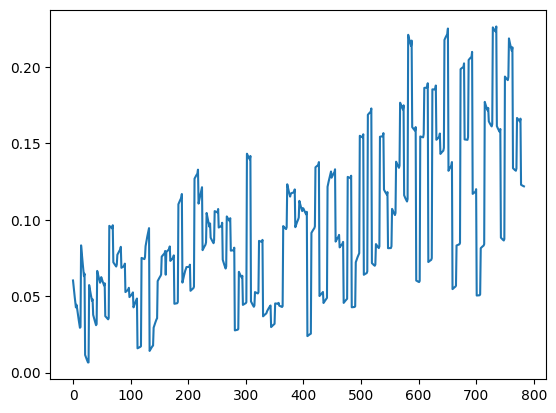

In [38]:
plt.plot(model.pc_conv1.energy_vals["mean_internal_energy_sign"][:])
plt.show()
plt.plot(model.pc_conv1.energy_vals["mean_sensory_energy_sign"][:])
plt.show()

In [ ]:
model.pc_conv1.energy_vals["internal_energy"][:]

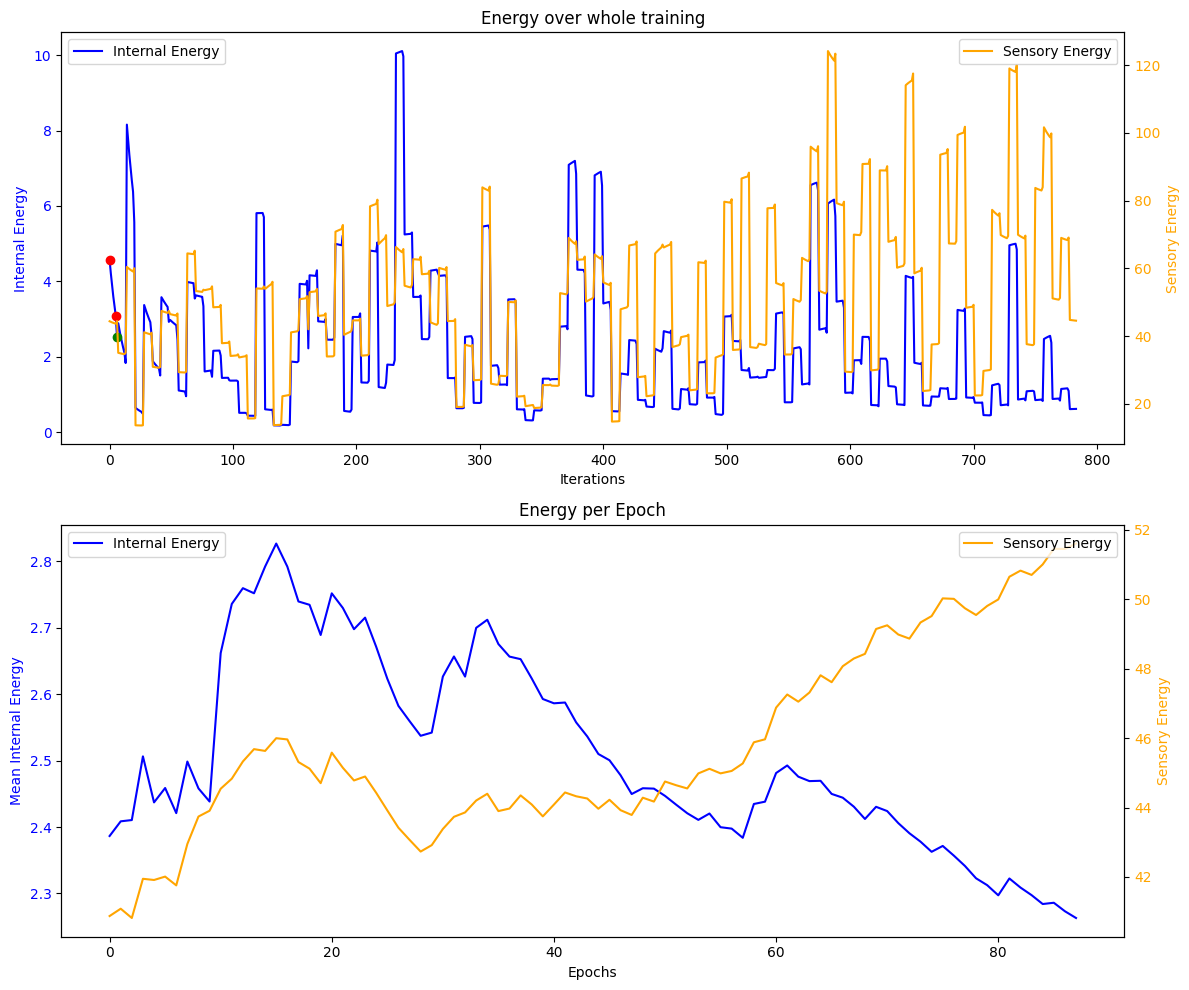

In [39]:
   
plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                            model.pc_conv1.energy_vals["sensory_energy"][:],
                            history, 
                            point1=(0, model.pc_conv1.energy_vals["internal_energy"][0]),
                            point2=(model.pc_conv1.T, model.pc_conv1.energy_vals["internal_energy"][model.pc_conv1.T]),
                            point3=((model.pc_conv1.T)+1, model.pc_conv1.energy_vals["internal_energy"][(model.pc_conv1.T)+1]),
                            model_dir=None,
                            epoch=epoch)

In [ ]:
plt.hist(model.pc_conv1.weights.cpu().detach().flatten(), bins=10)
plt.show()

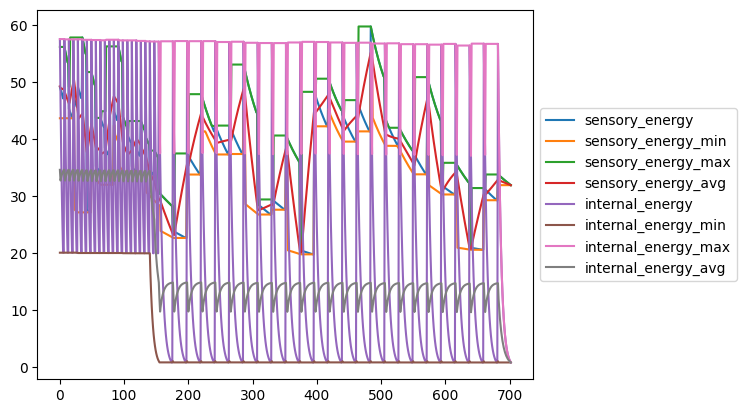

In [29]:
for tmp in ["sensory_energy","internal_energy"]:

    t = model.pc_conv1.energy_vals[tmp]
    plt.plot(t, label=f"{tmp}")

    v_min = []
    v_max = []
    v_avg = []

    for w in range(0, len(t)):

        window = t[w:w+model.pc_conv1.T]
        w_min = min(window)
        w_max = max(window)
        w_avg = sum(window)/len(window)

        # w_mean = 

        v_min.append(w_min)
        v_max.append(w_max)
        v_avg.append(w_avg)

    plt.plot(v_min, label=f"{tmp}_min")
    plt.plot(v_max, label=f"{tmp}_max")
    plt.plot(v_avg, label=f"{tmp}_avg")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

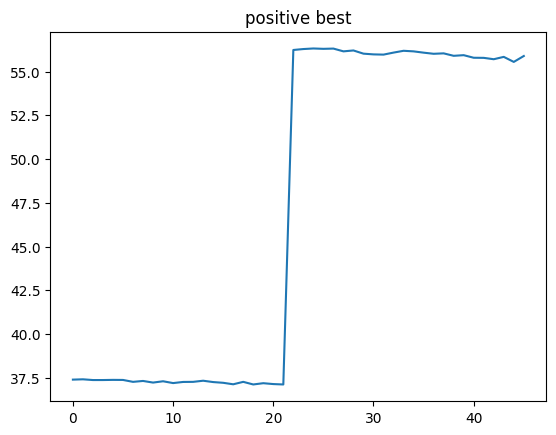

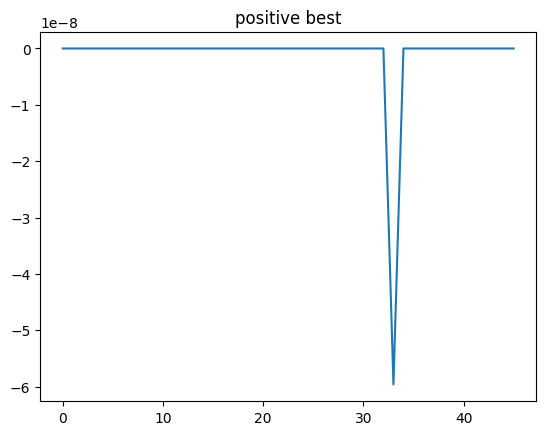

In [30]:
# weight_update_gain energy_drop

plt.plot(model.pc_conv1.energy_vals['energy_drop'])
plt.title("positive best")
plt.show()
plt.plot(model.pc_conv1.energy_vals['weight_update_gain'])
plt.title("positive best")
plt.show()


In [25]:
model.pc_conv1.energy_vals["energy_t0"]

[]

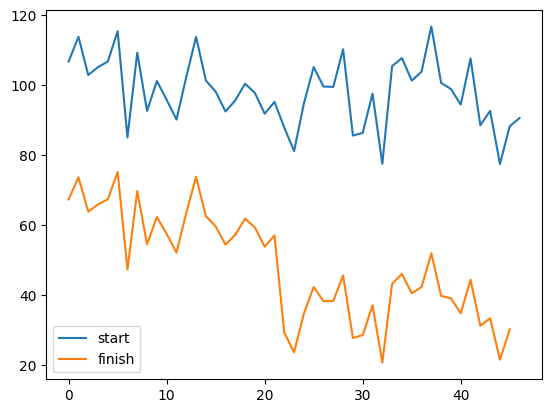

In [31]:
plt.plot(model.pc_conv1.energy_vals['energy_t0'], label="start")
plt.plot(model.pc_conv1.energy_vals['energy_tT'], label="finish")
plt.legend()
plt.show()


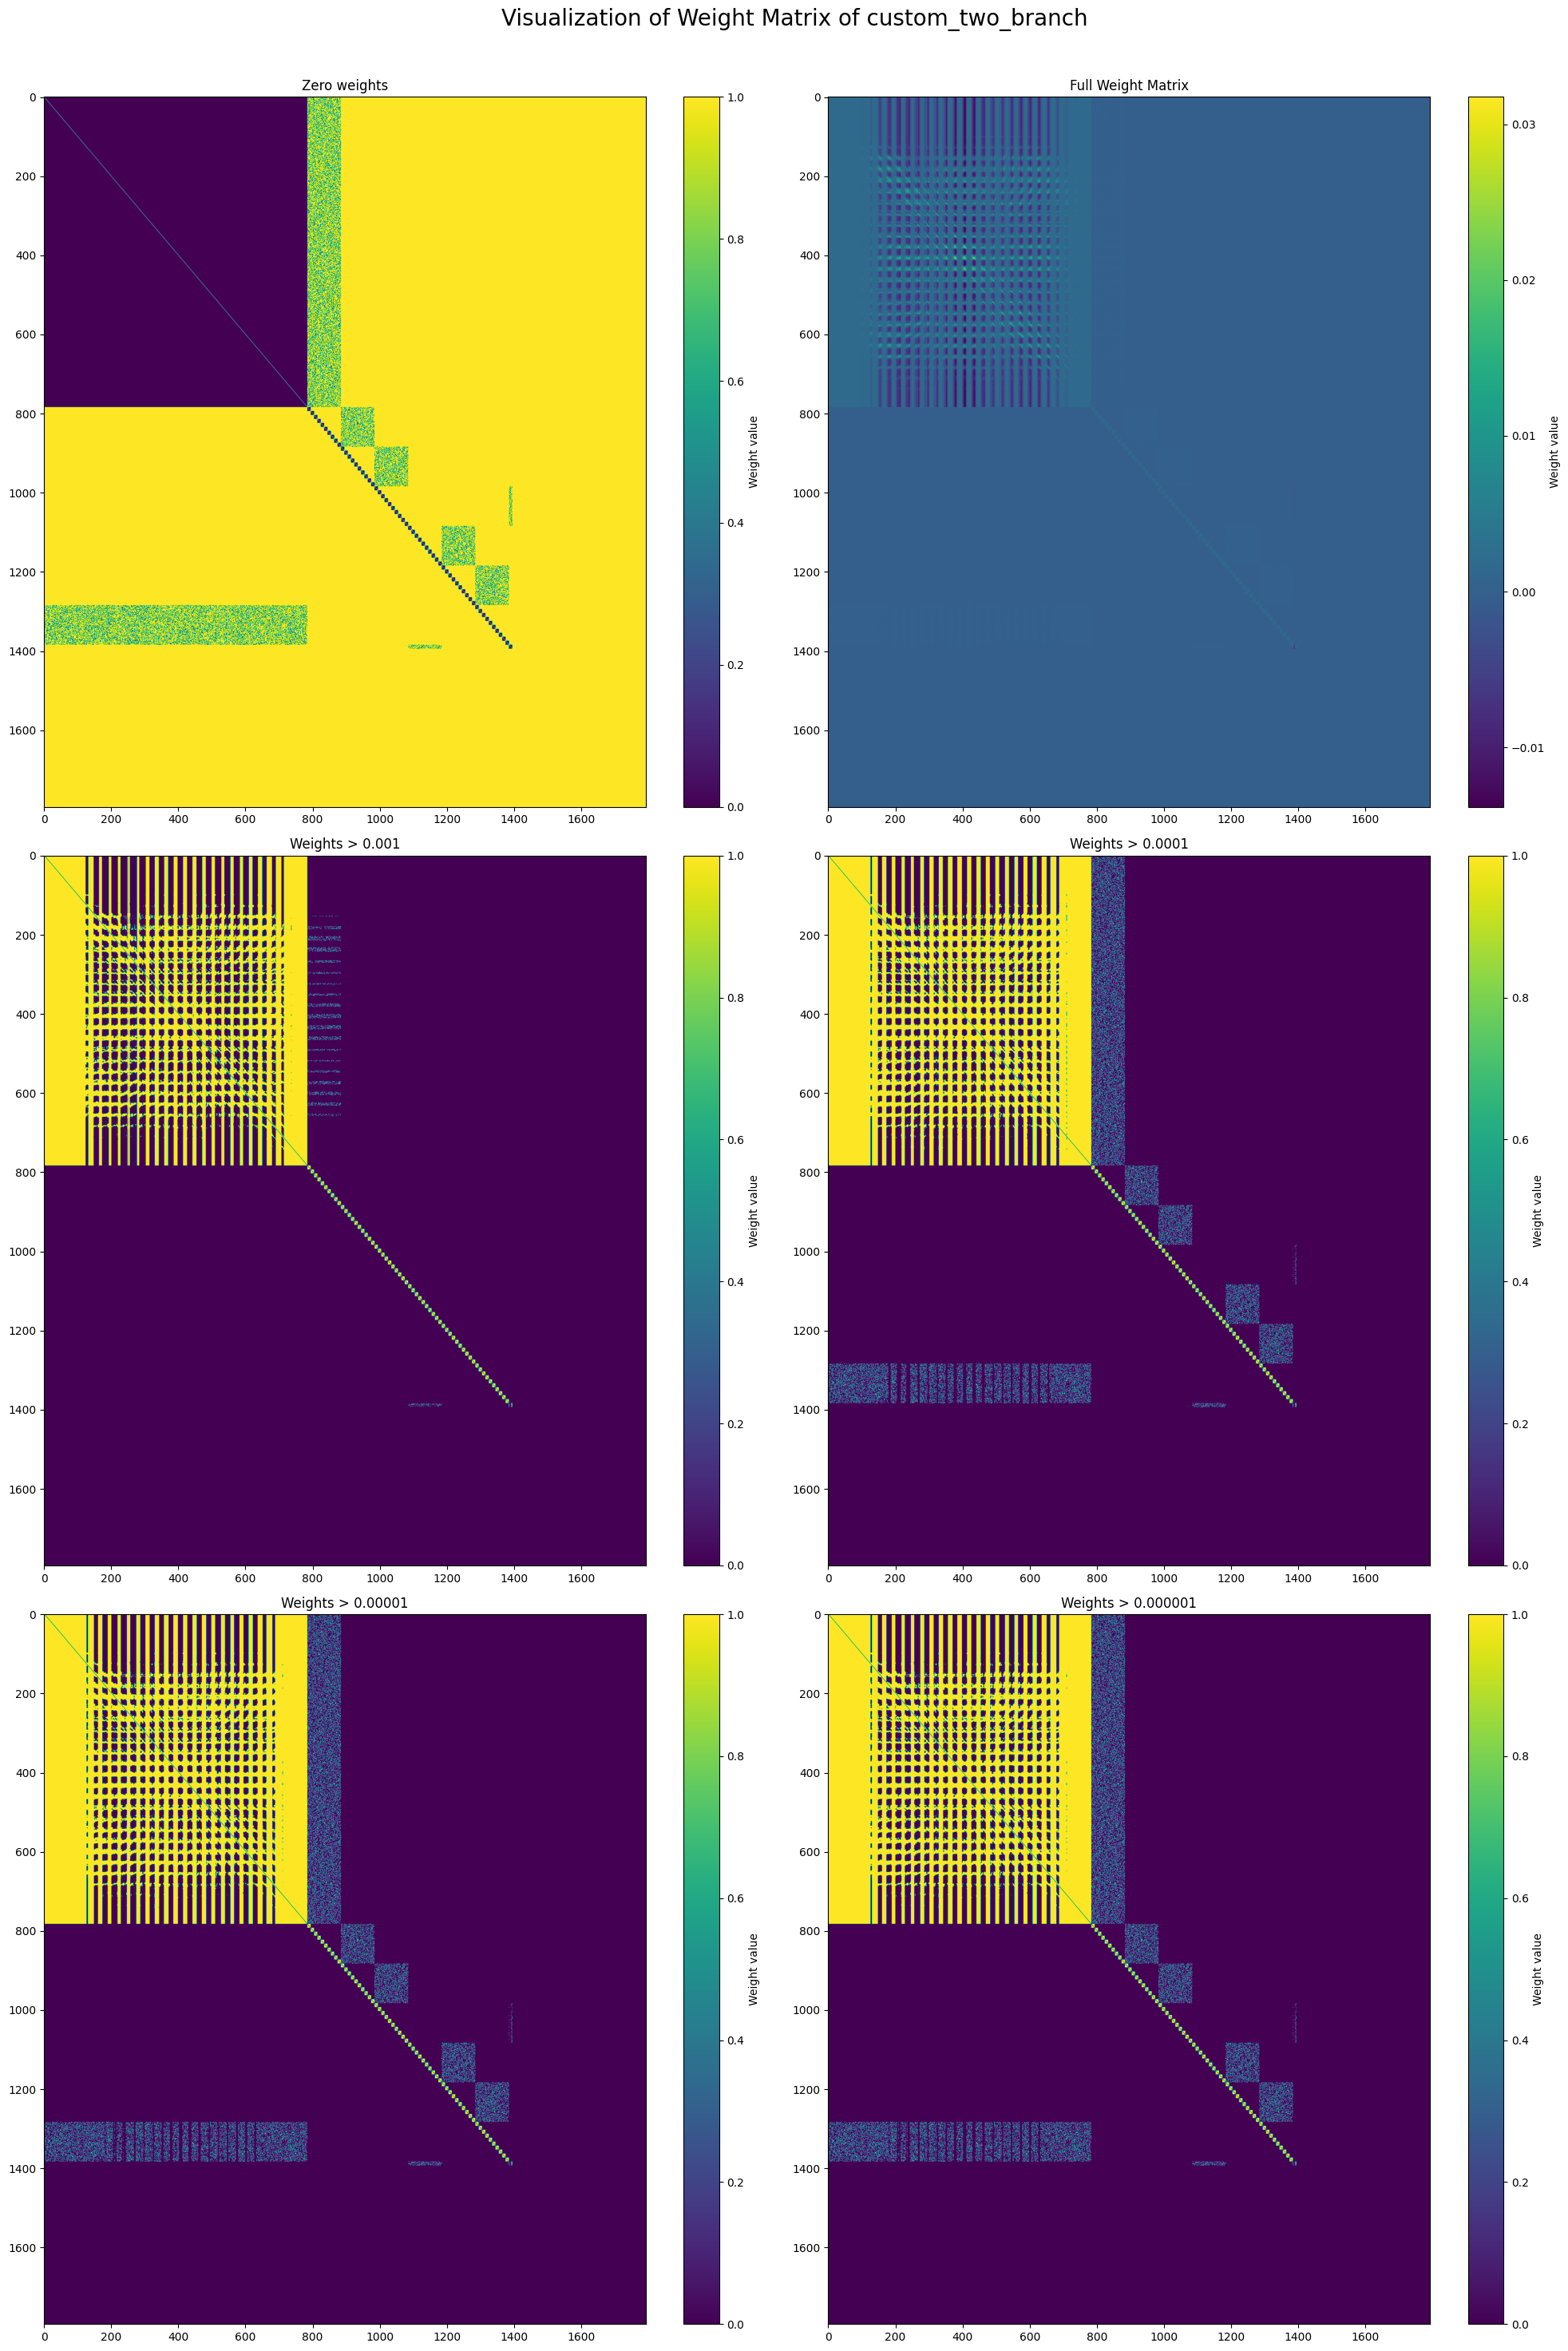

In [32]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
W = plot_model_weights(model, GRAPH_TYPE, model_dir=None)

In [40]:
# Save model weights 
######################################################################################################### 
####                                            Evaluation (setup)                                  #####
#############################################################################################s############ 
 
# device = torch.device('cpu')
from eval_tasks import classification, denoise, occlusion, generation #, reconstruction
model.pc_conv1.batchsize = 1


### Make dataloader for testing where we take all the digits of the number_list we trained on ###
dataset_params_testing = dataset_params.copy()

if "batch_size" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["batch_size"]

if "NUM_INTERNAL_NODES" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["NUM_INTERNAL_NODES"]

dataset_params_testing["edge_index"] = custom_dataset_train.edge_index

dataset_params_testing["mnist_dataset"] = mnist_testset
dataset_params_testing["N"] = "all"
dataset_params_testing["supervision_label_val"] = dataset_params["supervision_label_val"]



for key in dataset_params_testing:
    print(key, ":\t ", dataset_params_testing[key])


# CustomGraphDataset params
custom_dataset_test = CustomGraphDataset(graph_params, **dataset_params_testing, 
                                        indices=(num_vertices, sensory_indices, internal_indices, supervision_indices)
                                        )
# dataset_params_testing["batch_size"] = 2

test_loader = DataLoader(custom_dataset_test, batch_size=1, shuffle=True, generator=generator_seed)

mnist_dataset :	  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
supervised_learning :	  True
numbers_list :	  [0, 1, 2, 3, 4, 5, 6]
same_digit :	  False
add_noise :	  False
noise_intensity :	  0.0
N :	  all
edge_index :	  tensor([[   0,    0,    0,  ..., 1793, 1793, 1793],
        [   1,    2,    3,  ..., 1790, 1791, 1792]])
supervision_label_val :	  10
Supervised learning
Taking first n=all digits from each class
-----Done-----
1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 10

In [35]:
# 
# plot_model_weights(model, model_dir=None)

In [36]:
# for idx, (noisy_batch, clean_image) in enumerate(test_loader, start=1):
#     noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape

#     torch.rand(noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape).shape
#     break

In [41]:
def get_clean_images_by_label(mnist_train, num_images=10):
    """
    Extract num_images clean images for each label (0-9) from mnist_train.
    Returns a dictionary with labels as keys and a list of clean images as values.
    """
    clean_images = {label: [] for label in range(10)}

    for label in range(10):
        # Filter the indices for the current label
        class_indices = [i for i, lbl in enumerate(mnist_train.targets) if lbl == label]
        
        # Get the first num_images clean images for the current label
        clean_images[label] = [mnist_train[i][0].squeeze().numpy() for i in class_indices[:num_images]]

    return clean_images

# Example usage:
clean_images = get_clean_images_by_label(mnist_trainset, num_images=10)

model.trace(values=True, errors=True)


In [ ]:
model.pc_conv1.energy_vals["internal_energy_testing"]

        # self.pc_conv1.energy_vals["internal_energy_testing"] = []
        # self.pc_conv1.energy_vals["sensory_energy_testing"] = []

In [33]:
# model.enable_all_connections()

In [34]:
# # source_nodes = model.pc_conv1.edge_index[0]   # all i's 
# # target_nodes = model.pc_conv1.edge_index[1]   # all j's 

# # # Gather the corresponding errors and f_x values for each edge
# # # print("source_nodes shape", source_nodes.shape)
# # # print("errors shape", errors.shape)
# # # print("f_x shape", f_x.shape)
# # source_errors = model.pc_conv1.values[source_nodes].detach()    # get all e_i's 
# # target_fx = model.pc_conv1.values[target_nodes].detach()   

# # V = source_errors * target_fx

# V_p = V.reshape(model.pc_conv1.batchsize, model.pc_conv1.edge_index_single_graph.size(1)) 
# V_p.shape

In [ ]:
# Example matrices
# matrix_list = [np.random.rand(5, 5) for _ in range(10)]  # Create 10 random 5x5 matrices

# matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["values"] ] 
matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["preds"] ] 

matrix_list = [torch.ger(i, i) for i in matrix_list]

# Create diagonal matrices from each tensor
# matrix_list = [torch.diag(i) for i in matrix_list]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure and axis
fig, ax = plt.subplots()

matrix_list_show = matrix_list[:20]

# Display the first matrix
im = ax.imshow(matrix_list_show[0], cmap='viridis')
cbar = plt.colorbar(im)  # Add the color bar

# Function to update the matrix in each frame
def update(frame):
    im.set_array(matrix_list_show[frame])  # Update the data for the new frame
    return [im]

# Prevent static display of imshow() after the animation
plt.close()

# Create the animation
ani = FuncAnimation(fig, update, frames=len(matrix_list_show), blit=True, interval=500)

# Display the animation in the notebook
HTML(ani.to_jshtml())

In [55]:
import torch

# Create a copy of the current weights
w_copy = model.pc_conv1.weights.clone()

# plt.hist(w_copy.cpu().detach().flatten(), bins=10)
# plt.show()

In [56]:
# Define the threshold
threshold = 0.0001

# Apply the threshold: set weights with absolute values below the threshold to zero
new_w = torch.where(torch.abs(w_copy) < threshold, torch.tensor(0.0, device=w_copy.device), w_copy)

# Assign the thresholded weights back to the model
model.pc_conv1.weights.data = new_w

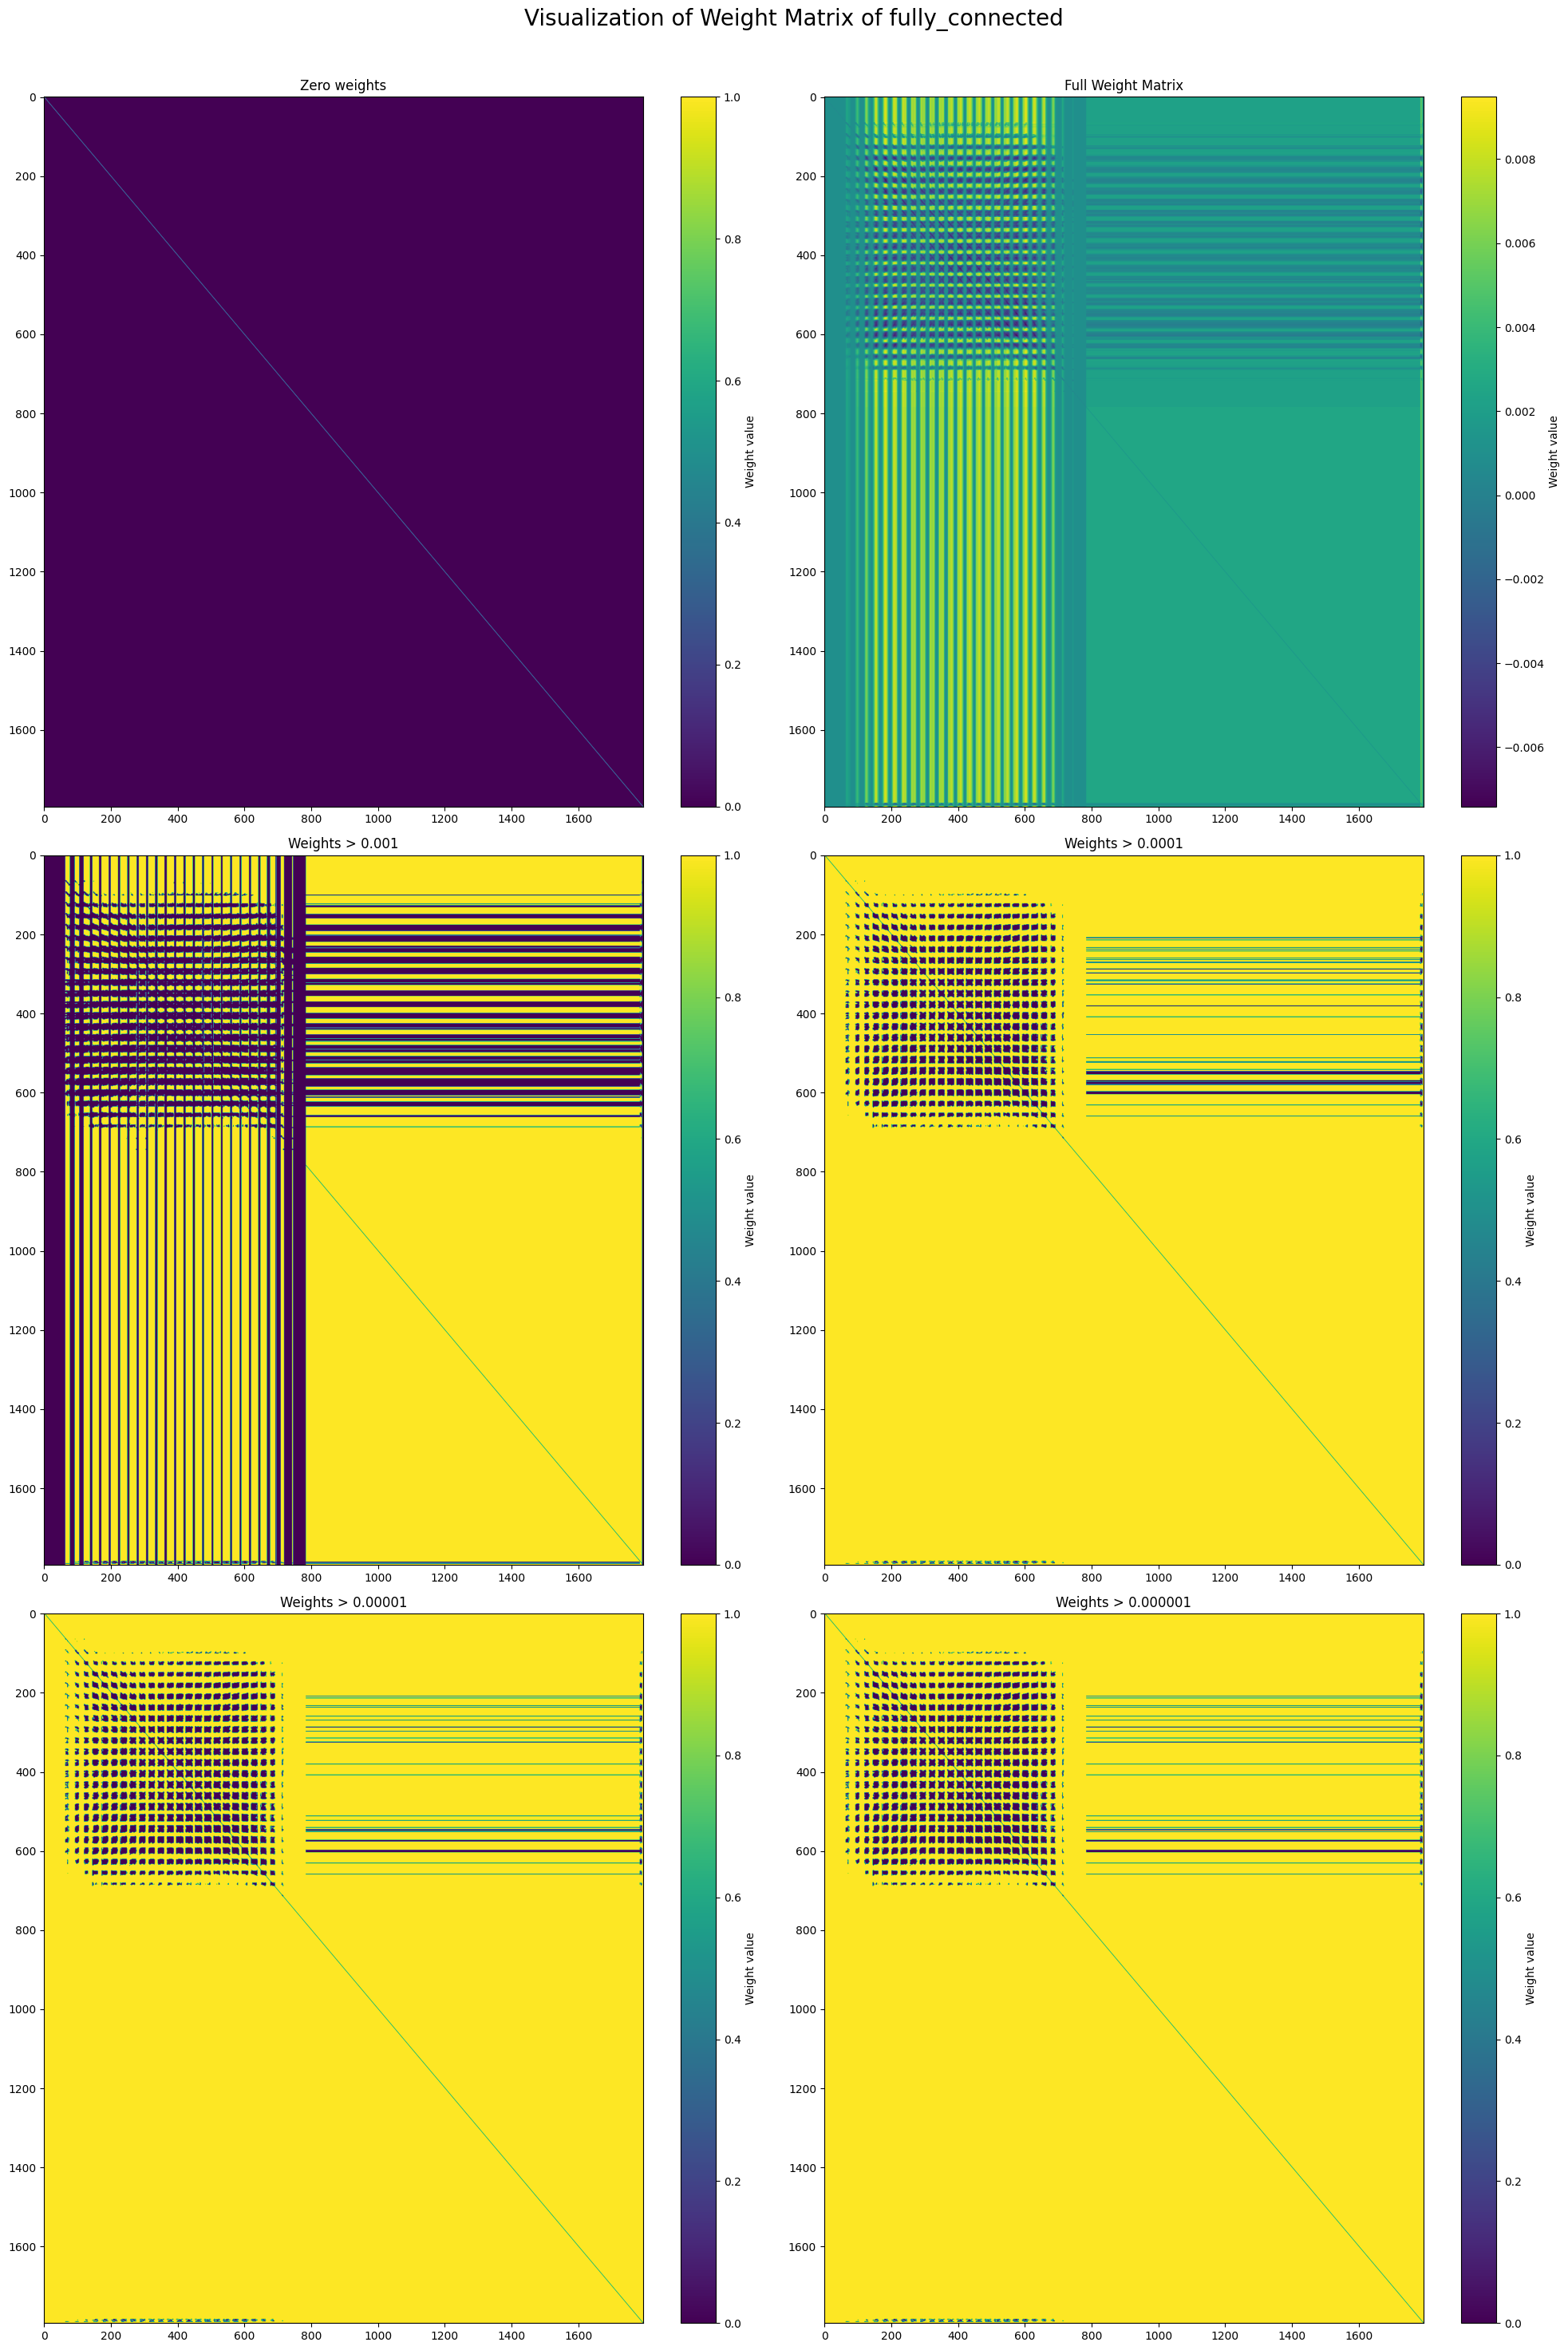

In [45]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
W = plot_model_weights(model, GRAPH_TYPE, model_dir=None)

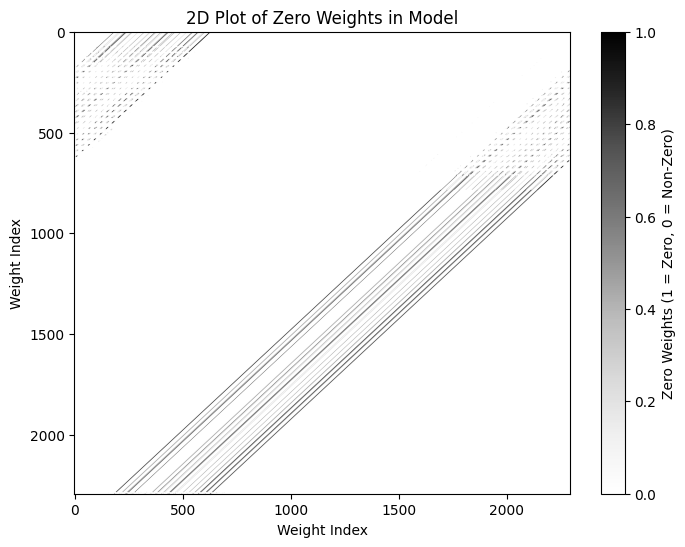

In [58]:
weights = model.pc_conv1.weights.detach().cpu().numpy()

# Identify zero weights and create a mask
zero_weights_mask = (weights == 0).astype(int)  # 1 where weight is zero, 0 elsewhere

# Plot the zero weights as a 2D heatmap
plt.figure(figsize=(8, 6))
plt.imshow(zero_weights_mask.reshape(int(len(weights)**0.5), -1), cmap="Greys", aspect="auto")
plt.colorbar(label="Zero Weights (1 = Zero, 0 = Non-Zero)")
plt.title("2D Plot of Zero Weights in Model")
plt.xlabel("Weight Index")
plt.ylabel("Weight Index")
plt.show()


-------------Restarting activity (pred/errors/values)--------------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task classification--------------
Done for idx 2071
Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS classification
Pass
torch.Size([1794])
Initial internal energy (t=0): 114.27680969238281


torch.Size([1794])
torch.Size([1794])


Iteration 2, Energy: {'internal_energy': 45.1154670715332, 'supervised_energy': 3.0600900650024414, 'sensory_energy': 198.57223510742188, 'energy_total': 246.74778747558594}:   1%|          | 1/90 [00:00<00:06, 13.58it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
trace len 90
Final internal energy (t=T): 0.5789706707000732
testing
Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 1.2605553 -0.09350069
Denoised val 1.0 0.0
tensor([-0.2382, -0.1313, -0.2521, -0.1895, -0.3089, -0.2020, -0.2767,  0.1292,
         0.1292,  0.1292], device='cuda:0')


KeyError: 'num_wandb_img_log'

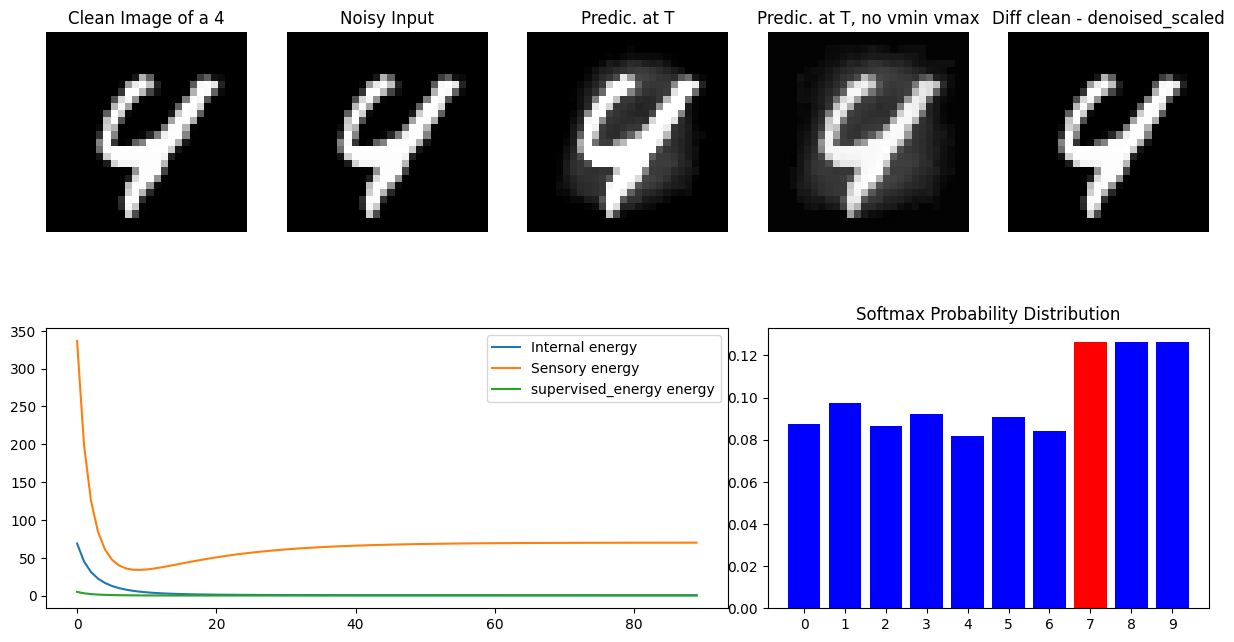

In [42]:

model.pc_conv1.batchsize = 1

test_params = {
    "model_dir": model_dir,
    "T":90,
    "supervised_learning":False, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

IMPORTANT SEE OLD OCCLUSION func; 
-------------Restarting activity (pred/errors/values)--------------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task generation--------------
Occulusion model.pc_conv1.values.shape torch.Size([1794, 1])
-------------Restarting activity (pred/errors/values)--------------
No vmin vmax
Done for idx 1065
tensor([4])
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
aaa testing
CHECK tensor([[0.9289],
        [0.4333],
        [0.8850],
        [0.0210],
        [0.6515],
        [0.2185],
        [0.6497],
        [0.0495],
        [0.2649],
        [0.5189]], device='cuda:0')


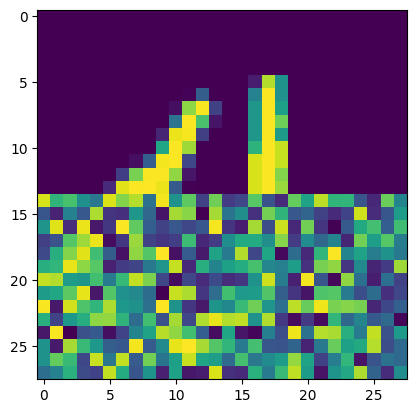

Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS generation
Pass
-------------Restarting activity (pred/errors/values)--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 107.11955261230469


Total energy at time 8 / 50 {'internal_energy': 20.443359375, 'supervised_energy': 0.08231235295534134, 'sensory_energy': 32.66456985473633, 'energy_total': 54.12461853027344},:  10%|█         | 5/50 [00:00<00:00, 48.43it/s]       

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 10 / 50 {'internal_energy': 13.501029968261719, 'supervised_energy': 0.054317835718393326, 'sensory_energy': 30.381166458129883, 'energy_total': 44.898887634277344},:  20%|██        | 10/50 [00:00<00:00, 46.63it/s]

torch.Size([1794])


Total energy at time 17 / 50 {'internal_energy': 3.151792526245117, 'supervised_energy': 0.01269468478858471, 'sensory_energy': 26.0538330078125, 'energy_total': 30.222312927246094},:  30%|███       | 15/50 [00:00<00:00, 42.30it/s]    

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 18 / 50 {'internal_energy': 2.559354305267334, 'supervised_energy': 0.010315850377082825, 'sensory_energy': 25.70354461669922, 'energy_total': 29.279586791992188},:  30%|███       | 15/50 [00:00<00:00, 42.30it/s]

torch.Size([1794])
torch.Size([1794])


Total energy at time 26 / 50 {'internal_energy': 0.481685996055603, 'supervised_energy': 0.001964718569070101, 'sensory_energy': 23.99186134338379, 'energy_total': 25.490238189697266},:  50%|█████     | 25/50 [00:00<00:00, 42.15it/s]   

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 28 / 50 {'internal_energy': 0.3168703317642212, 'supervised_energy': 0.0012985640205442905, 'sensory_energy': 23.750886917114258, 'energy_total': 25.08444595336914},:  50%|█████     | 25/50 [00:00<00:00, 42.15it/s]

torch.Size([1794])
torch.Size([1794])


Total energy at time 34 / 50 {'internal_energy': 0.09029009193181992, 'supervised_energy': 0.00037540055927820504, 'sensory_energy': 23.258071899414062, 'energy_total': 24.36505126953125},:  60%|██████    | 30/50 [00:00<00:00, 41.25it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 36 / 50 {'internal_energy': 0.059627704322338104, 'supervised_energy': 0.0002483261050656438, 'sensory_energy': 23.146799087524414, 'energy_total': 24.22311782836914},:  70%|███████   | 35/50 [00:00<00:00, 40.16it/s]

torch.Size([1794])
torch.Size([1794])


Total energy at time 43 / 50 {'internal_energy': 0.015062253922224045, 'supervised_energy': 5.8559828175930306e-05, 'sensory_energy': 22.882083892822266, 'energy_total': 23.913835525512695},:  80%|████████  | 40/50 [00:01<00:00, 40.26it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 44 / 50 {'internal_energy': 0.012638751417398453, 'supervised_energy': 4.7649809857830405e-05, 'sensory_energy': 22.855684280395508, 'energy_total': 23.885011672973633},:  80%|████████  | 40/50 [00:01<00:00, 40.26it/s]

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
Final internal energy (t=T): 0.005594282411038876
Inference completed.
QUery by condition or query by init
CHECK tensor([[0.9289],
        [0.4333],
        [0.8850],
        [0.0210],
        [0.6515],
        [0.2185],
        [0.6497],
        [0.0495],
        [0.2649],
        [0.5189]], device='cuda:0')
Predic. at T, no vmin vmax 0.7549438 -0.28946728
Denoised val 1.0 0.0
generation_task_4.png
CHECK tensor([[0.9289],
        [0.4333],
        [0.8850],
        [0.0210],
        [0.6515],
        [0.2185],
        [0.6497],
        [0.0495],
        [0.2649],
        [0.5189]], device='cuda:0')


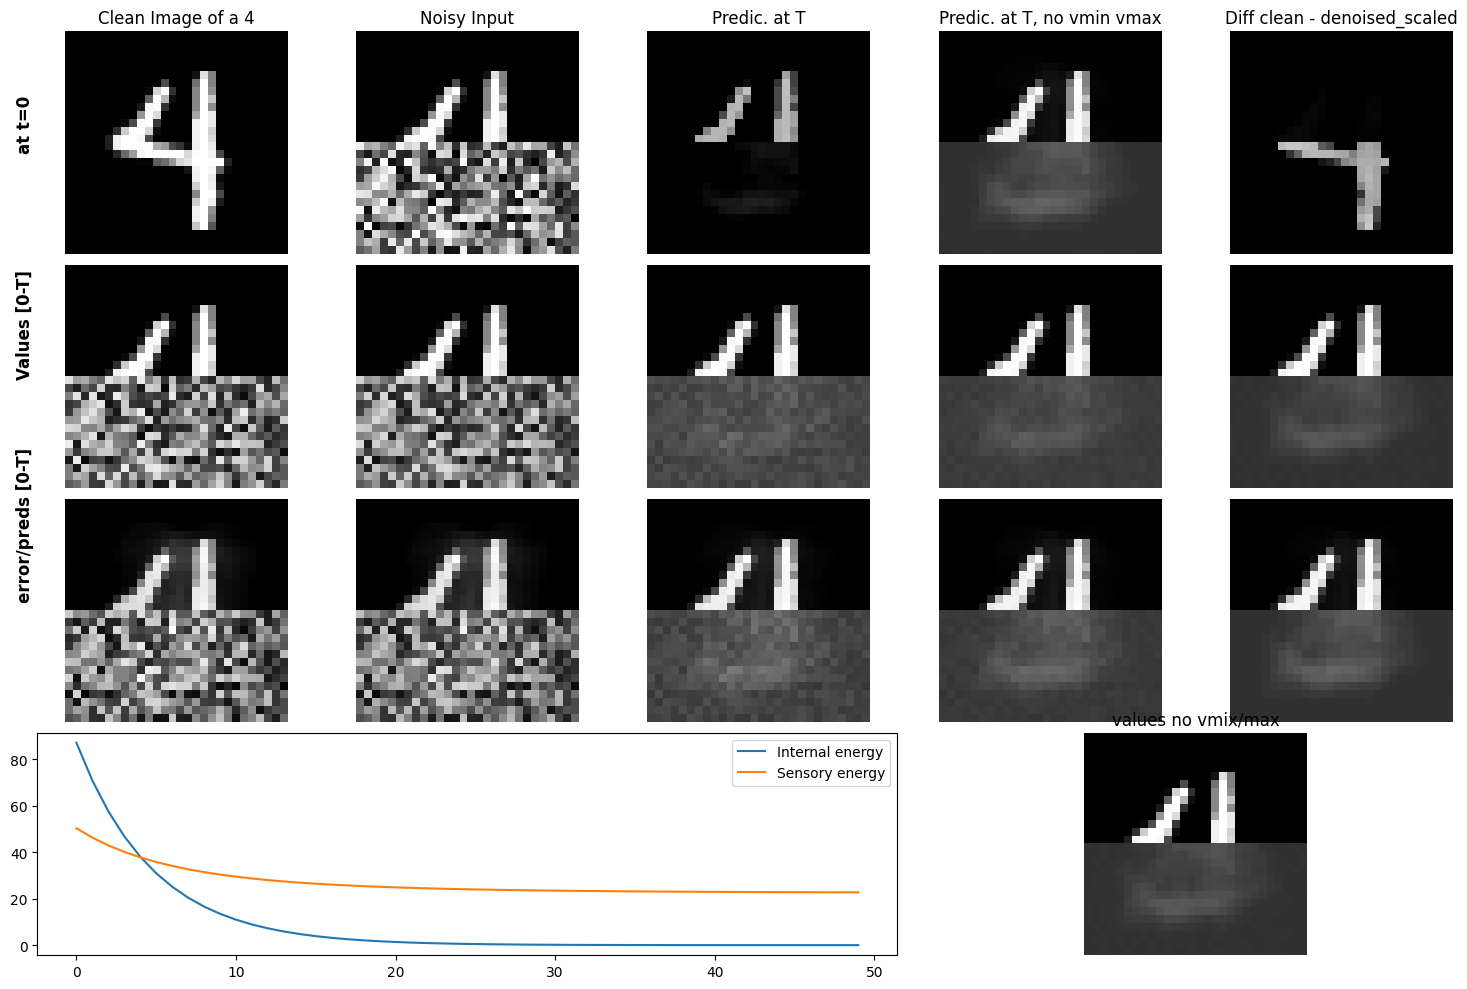

In [32]:


model.pc_conv1.batchsize = 1

######################################################################################################### 
####                                            Evaluation (tasks)                                  #####
######################################################################################################### 
 
test_params = {
    "model_dir": None,
    "T": 50,
    "supervised_learning":False, 
    "num_samples": 1,
    "add_sens_noise": True,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1 
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_occ = occlusion(test_loader, model, test_params)

In [ ]:
MSE_values_occ

In [ ]:


######################################################################################################### 

######################################################################################################### 

test_params["add_sens_noise"] = True
MSE_values_occ_noise = occlusion(test_loader, model, test_params)

test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 6,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_denoise_sup = denoise(test_loader, model, test_params)

test_params["supervised_learning"] = False
MSE_values_denoise = denoise(test_loader, model, test_params)
                            
# MSE_values = denoise(test_loader, model, supervised_learning=True)
# print("MSE_values", MSE_values)
######################################################################################################### 



# # MSE_values = denoise(test_loader, model, supervised_learning=True)
# # print("MSE_values", MSE_values)


# print("accuracy_mean", accuracy_mean)

# print("model_dir", model_dir)

# # write a text file with these 


# # Open the file in write mode
# with open(model_dir + "eval/eval_scores.txt", 'w') as file:
#     # Write each list to the file

#     file.write("MSE_values_denoise_sup:\n")
#     file.write(", ".join(map(str, MSE_values_denoise_sup)) + "\n\n")

#     file.write("MSE_values_denoise:\n")
#     file.write(", ".join(map(str, MSE_values_denoise)) + "\n\n")
    
#     file.write("MSE_values_occ_noise:\n")
#     file.write(", ".join(map(str, MSE_values_occ_noise)) + "\n\n")
    
#     file.write("MSE_values_occ:\n")
#     file.write(", ".join(map(str, MSE_values_occ)) + "\n\n")

#     file.write("accuracy_mean:\n")
#     file.write("y_true: " + ", ".join(map(str, y_true)) + "\n")
#     file.write("y_pred: " + ", ".join(map(str, y_pred)) + "\n")
    
#     file.write(str(accuracy_mean) + "\n\n")


# from datetime import datetime
# # Get the current date and time
# current_datetime = datetime.now()
# # Print the current date and time
# print("Current date and time:", current_datetime)



# wandb.log({"accuracy_mean": accuracy_mean})
# # wandb.log({"energy_sensory": energy["sensory_energy"]})






# wandb.finish()

In [15]:
# model.Disable_connection(from_indices=sensory_indices, 
#                          to_indices=supervision_indices)

In [ ]:
# model.enable_all_connections()

In [ ]:
plt.imshow(model.pc_conv1.trace['preds'][0][0:784].view(28,28).cpu())
plt.show()

In [ ]:
tr = model.pc_conv1.trace["values"]
len(tr)

In [ ]:
model.pc_conv1.mode

In [28]:
a = model.pc_conv1.weights.cpu().detach()

print(a.min(), a.max(), a.mean())

tensor(-0.0180) tensor(0.0381) tensor(0.0010)


-------------Restarting activity (pred/errors/values)--------------
-------------Restarting activity (pred/errors/values)--------------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task generation--------------
Done for idx 4563
labels model tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS generation
Pass
torch.Size([1794])
Initial internal energy (t=0): 317.7159118652344


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Iteration 76, Energy: {'internal_energy': 0.028467804193496704, 'supervised_energy': 50.023902893066406, 'sensory_energy': 0.0714658871293068, 'energy_total': 50.123844146728516}:  75%|███████▌  | 75/100 [00:02<00:01, 23.62it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
trace len 100
Final internal energy (t=T): 0.02311655879020691
testing
Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.010923218 -0.029107273
Denoised val 0.06036386 -0.056963794
ssim_values [-0.119401453677009]
mse_values [0.35301855]
ssim_values [-0.119401453677009, -0.06275339338712592]
mse_values [0.35301855, 0.33425412]
ssim_values [-0.119401453677009, -0.06275339338712592, -0.1370448134851613]
mse_values [0.35301855, 0.33425412, 0.34474576]
ssim_values [-0.119401453677009, -0.06275339338712592, -0.1370448134851613, -0.1624095813294026]
mse_values [0.35301855, 0.33425412, 0.34474576, 0.36373162]
ssim_values [-0.119401453677009, -0.06275339338712592, -0.1370448134851613, -0.1624095813294026, -0.058942440056048026]
mse_values [0.35301855, 0.33425412, 0.34474576, 0.36373162, 0.33852473]
ssim_values [-0.119401453677009, -0.06275339338712592, -0.1370448134851613, -0.1624095813294026, -0.058942440056048026, -0.08773545023649142]
m

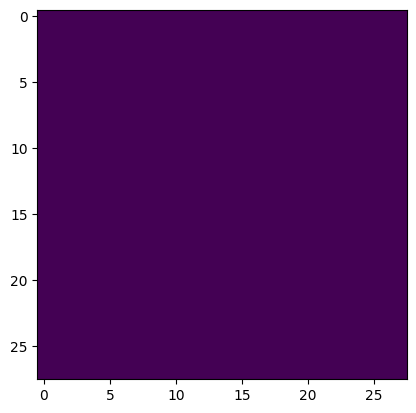

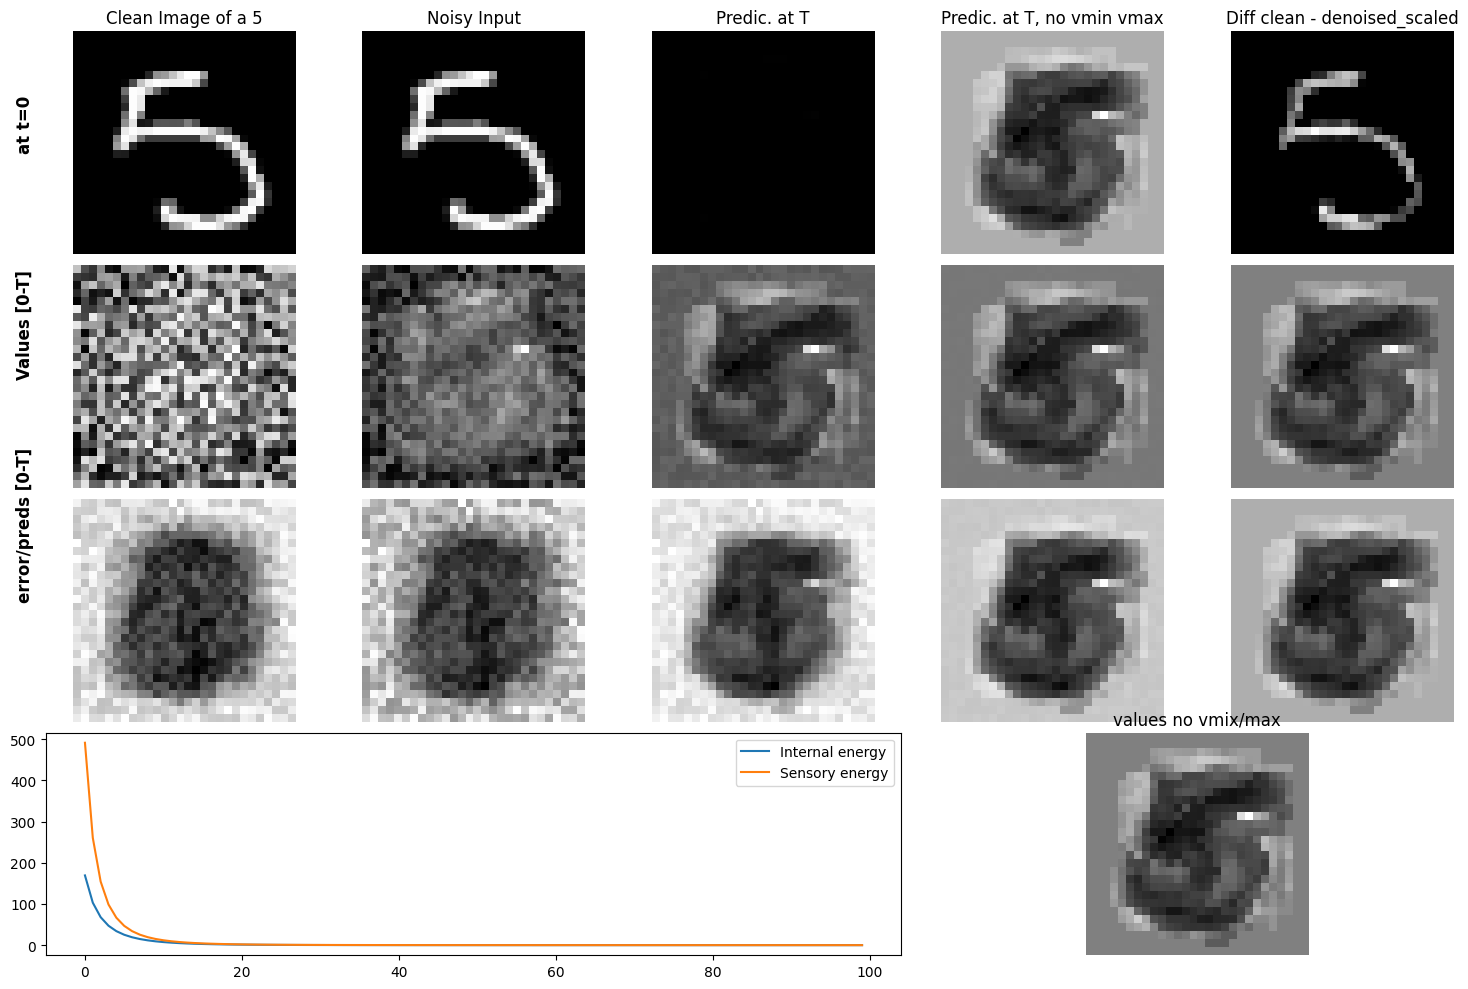

In [44]:
test_params = {
    "model_dir": model_dir,
    "T":100,
    "supervised_learning":True, 
    "num_samples": 1,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
model.pc_conv1.trace_activity_values = True 
model.pc_conv1.trace_activity_preds = True 

model.pc_conv1.restart_activity()

avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max = generation(test_loader, model, test_params, clean_images, verbose=1)
                            

[5,
 5,
 5,
 2,
 4,
 1,
 3,
 3,
 2,
 1,
 1,
 3,
 1,
 2,
 3,
 3,
 4,
 6,
 6,
 3,
 1,
 2,
 4,
 5,
 2,
 6,
 1,
 6,
 3,
 3]

In [ ]:
len(model.pc_conv1.trace["values"]), len(model.pc_conv1.trace["preds"])

In [ ]:
avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max

In [ ]:
a = model.pc_conv1.trace["values"]

a[0] == a[10]

In [ ]:
tr = model.pc_conv1.trace["values"]
print(len(tr))
# for img in tr:
#     plt.imshow(img[0:784].view(28,28).cpu().detach().numpy())
#     plt.show()

In [ ]:
# len(model.pc_conv1.trace["values"])
plt.imshow(model.pc_conv1.trace["values"][0][0:784].view(28,28).cpu())

In [50]:
import math 
# Define the range for logarithmic initialization
log_min = 1e-4  # Minimum value in the range
log_max = 1e-1  # Maximum value in the range
# num_weights = self.edge_index_single_graph.size(1)  # Number of weights to initialize
num_weights = 100  # Number of weights to initialize

# Initialize weights logarithmically between log_min and log_max
log_weights = torch.logspace(math.log10(log_min), math.log10(log_max), steps=num_weights)

# # Simulate a lognormal distribution for synaptic weights based on the description
# mu, sigma = 0, 1  # Mean and standard deviation for lognormal distribution
# weights = np.random.lognormal(mu, sigma, 1000)

# Using batch size, we want the same edge weights at each subgraph of the batch
# weights = torch.nn.Parameter(log_weights)
weights = log_weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the histogram of the weights
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=50, density=True, alpha=0.75, color='b')
plt.title('Lognormal Distribution of Synaptic Weights')
plt.xlabel('Weight')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()